December 1, 2020

Code by Jordan Lanius.

#Activity Recognition Project Phase III

## Definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys
import time

from google.colab import files
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
# Constants
DATA_FILE = 'ElderlyActivityDataBed.csv'
DATA_COLUMNS = (1, 3, 4, 5, 6, 7, 8, 9, 10)
DELIMITER = ','
FLOAT_FORMAT = '{: 0.2f}'
SPLIT_RATIO = 0.3
CHECKPOINT = 'checkpoint.hdf5'
PATIENCE = 50
TARGET_ACCURACY = 0.98

### Functions

#### General

In [3]:
# Progress Bar
def update_progress(progress):
    barLength = 20 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rProgress: [{}] {:.2f}% {}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [4]:
# Build a model using the given architecture
def build_model(architecture, inputs):
  initLayer = architecture[len(architecture) - 1]

  model = Sequential()
  model.add(Dense(initLayer[0], input_dim=inputs, activation=initLayer[1]))
  for lyr in reversed(range(len(architecture) - 1)):
    layer = architecture[lyr]
    model.add(Dense(layer[0], activation=layer[1]))

  return model

In [5]:
# Train the given model
def train_model_acc(model, training, validation, compilation, fit):
  callback_a = ModelCheckpoint(filepath=CHECKPOINT, monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=0)
  callback_b = EarlyStopping(monitor='val_acc', mode='max', patience=PATIENCE, verbose=0)

  model.compile(loss=compilation[0], optimizer=compilation[1], metrics=compilation[2])
                
  history = model.fit(training[0], training[1], validation_data=validation,
                      batch_size=fit[0], epochs=fit[1], callbacks=[callback_a, callback_b], verbose=0)

  return history

In [6]:
# Evaluate the model
def evaluate_model_acc(model, history, training, validation):
  model.load_weights(CHECKPOINT)

  results = model.evaluate(training[0], training[1], verbose=0)
  val_results = model.evaluate(validation[0], validation[1], verbose=0)
  val_acc = val_results[2]
  
  return val_acc

In [7]:
# Display hyperparameters
def display_hyperparameters_acc(hyperparameters):
  print("Layers: ", hyperparameters[0])
  print("Neurons: ", hyperparameters[1])
  print("Activation: ", hyperparameters[2])
  print("Optimization: ", hyperparameters[3])
  print("Batch Size: ", hyperparameters[4])
  print("Epochs: ", hyperparameters[5])

In [8]:
#Calculate and display statistics
def model_statistics(model, training, validation):
  predTraining = model.predict(training[0])
  predValidation = model.predict(validation[0])

  accTraining = accuracy_score(training[1], predTraining.round())
  precision = precision_score(training[1], predTraining.round())
  recall = recall_score(training[1], predTraining.round())
  f1 = f1_score(training[1], predTraining.round())
  accValidation = accuracy_score(validation[1], predValidation.round())

  print("\nPredictions:")
  print("  Accuracy: %.2f%%" % (accTraining * 100.0))
  print("  Precision: %.2f%%" % (precision * 100.0))
  print("  Recall: %.2f%%" % (recall * 100.0))
  print("  F1-score: %.2f" % (f1))
  print("  Validation Accuracy: %.2f%%" % (accValidation * 100.0))

In [9]:
# Display information
def display_information_acc(model, history):
  fig, ax = plt.subplots();
  ax.plot(history.history['acc'])
  ax.plot(history.history['val_acc'])
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  ax.legend(['Training Data', 'Validation Data'], loc='lower right')
  plt.show()

#### Hyperparameter Optimization

In [10]:
# Find models with significantly high accuracies
def optimize_hyperparameters_acc(training, validation, layersArr, neuronsArr, activationsArr, optimizationsArr, batchSizesArr, epochsArr):
  bestHyperparameters = [[0, 0, 0, 0, 0, 0]]
  bestModel = [0]
  bestHistory = [0]
  bestAcc = [0]
  best = 0;

  size = len(layersArr) * len(neuronsArr) * len(activationsArr) * len(optimizationsArr) * len(batchSizesArr) * len(epochsArr)
  print('Testing ' + str(size) + ' sets of hyperparameters.\n')
  index = 0
  update_progress(index / size)

  for layerTest in layersArr:
    for neuronsTest in neuronsArr:
      for activationTest in activationsArr:
        architecture = [[1, 'sigmoid']]
        for lyr in range(layerTest - 1):
          architecture.append([neuronsTest, activationTest])

        for optimizationTest in optimizationsArr:
          compilation = ['mse', optimizationTest, ['mse', 'acc']]

          for batchSizeTest in batchSizesArr:
            for epochsTest in epochsArr:
              fit = [batchSizeTest, epochsTest]

              model = build_model(architecture, len(training[0][0,:]))
              history = train_model_acc(model, training, validation, compilation, fit)
              acc = evaluate_model_acc(model, history, training, validation)

              if acc >= TARGET_ACCURACY:
                bestHyperparameters.append([layerTest, neuronsTest, activationTest, optimizationTest, batchSizeTest, epochsTest])
                bestModel.append(model)
                bestHistory.append(history)
                bestAcc.append(acc)

                if best == 0:
                  best += 1
                elif acc > bestAcc[best]:
                  best = len(bestAcc) - 1

              index += 1
              update_progress(index / size)

  if best > 0:
    for paramIndex in range(1, len(bestHyperparameters)):
      print("\n------------------------------------")
      display_hyperparameters_acc(bestHyperparameters[paramIndex])
      model_statistics(bestModel[paramIndex], training, validation)
      print()
      display_information_acc(bestModel[paramIndex], bestHistory[paramIndex])
      print("------------------------------------\n")

    print("\n----- 'Best' Hyperparamaters -----")
    display_hyperparameters_acc(bestHyperparameters[best])
    model_statistics(bestModel[best], training, validation)
    print()
    display_information_acc(bestModel[best], bestHistory[best])

  return bestHyperparameters[best]

#### Recursive Feature Elimination

In [11]:
def rfe_individual_acc(headers, training, validation, architecture, compilation, fit):
  accValues = {}

  for feat in range(len(headers) - 1):
    # Isolate individual feature
    indTraining = (training[0][:,feat], training[1])
    indValidation = (validation[0][:,feat], validation[1])

    # Build, Train, and Evaluate model
    model = build_model(architecture, 1)
    history = train_model_acc(model, indTraining, indValidation, compilation, fit)
    accValues[headers[feat]] = evaluate_model_acc(model, history, indTraining, indValidation)

    # Display each learning curve
    plt.figure()
    plt.plot(history.history['acc'], label='Training')
    plt.plot(history.history['val_acc'], label='Validation')
    plt.title('Only ' + headers[feat])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

  return accValues

In [34]:
def rfe_exclusion_acc(columnRanks, headers, training, validation, architecture, compilation, fit):
  lossValues = {}

  title = 'All Features'
  exclTraining = training
  exclValidation = validation

  while len(columnRanks) > 0:
    # Build, Train, and Evaluate model
    model = build_model(architecture, len(columnRanks))
    history = train_model_acc(model, exclTraining, exclValidation, compilation, fit)
    lossValues[title] = evaluate_model_acc(model, history, exclTraining, exclValidation)

    # Display each learning curve
    plt.figure()
    plt.plot(history.history['acc'], label='Training')
    plt.plot(history.history['val_acc'], label='Validation')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    # Remove least important feature
    exclTraining = (np.delete(exclTraining[0], columnRanks[0], axis=1), exclTraining[1])
    exclValidation = (np.delete(exclValidation[0], columnRanks[0], axis=1), exclValidation[1])

    column = columnRanks.pop(0)
    for index in range(len(columnRanks)):
      if columnRanks[index] > column:
        columnRanks[index] -= 1
 
    title = 'After removing ' + headers.pop(column)

  return lossValues

##Dataset

###Upload Data

In [13]:
# Input dataset 'ElderlyActivityDataBed.csv'
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Pandas
data = pd.read_csv(DATA_FILE, delimiter=DELIMITER, usecols=DATA_COLUMNS)
columnNames = list(data.columns)
print("Columns: ")
print(columnNames)
print("\nData:")
data.head()

Columns: 
['Gender', 'FrontalAcceleration', 'VerticalAcceleration', 'LateralAcceleration', 'AntennaID', 'RSSI', 'Phase', 'Frequency', 'Activity']

Data:


,Gender,FrontalAcceleration,VerticalAcceleration,LateralAcceleration,AntennaID,RSSI,Phase,Frequency,Activity
0,0,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,0
1,0,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,0
2,0,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,0
3,0,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,0
4,0,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,0


In [15]:
# Numpy
dataset = np.genfromtxt(DATA_FILE, delimiter=DELIMITER, skip_header=True, usecols=DATA_COLUMNS)
np.random.shuffle(dataset)
np.set_printoptions(formatter = {'float': FLOAT_FORMAT.format})
print("Shape: " + str(dataset.shape))
print("\nDataset:")
print(dataset[0:5])

Shape: (52482, 9)

Dataset:
[[ 1.00  0.45  0.93 -0.04  2.00 -56.00  6.28  921.75  1.00]
 [ 0.00  0.21  0.99  0.07  4.00 -56.50  0.82  923.25  0.00]
 [ 1.00  0.98  0.11 -0.09  1.00 -56.50  1.56  922.75  0.00]
 [ 1.00  0.40  0.96 -0.09  3.00 -60.00  4.70  920.25  0.00]
 [ 0.00  1.32 -0.03  0.05  4.00 -65.50  0.07  920.75  0.00]]


###Clean Data

In [16]:
# Get dataset information
print(np.isnan(dataset))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [17]:
# Clear any empty entries
dataset = dataset[~np.isnan(dataset).any(axis=1)]
print(dataset.shape)

(52482, 9)


###Data Analysis

In [18]:
# Create a dataframe
datasetFrame = pd.DataFrame(data = dataset, columns = columnNames)

In [19]:
# Find ratio of output
datasetFrame['Activity'].value_counts()

0.0    46145
1.0     6337
Name: Activity, dtype: int64

In [20]:
# Find distributions of input features
datasetFrame.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,52482.0,0.479993,0.499604,0.00000,0.000000,0.000000,1.000000,1.0000
FrontalAcceleration,52482.0,0.805042,0.396362,-0.74808,0.424460,0.952100,1.128000,1.5032
VerticalAcceleration,52482.0,0.377804,0.468899,-0.55349,-0.025263,0.135500,0.916360,2.0302
LateralAcceleration,52482.0,0.007710,0.180674,-0.48121,-0.093505,-0.025087,0.066138,1.2178
AntennaID,52482.0,2.360752,1.261542,1.00000,1.000000,3.000000,4.000000,4.0000
RSSI,52482.0,-58.430814,4.611220,-70.00000,-61.500000,-57.500000,-56.500000,-38.5000
Phase,52482.0,3.275907,2.240341,0.00000,0.951070,4.072700,5.425700,6.2817
Frequency,52482.0,922.762261,1.693769,920.25000,921.250000,922.750000,924.250000,925.7500
Activity,52482.0,0.120746,0.325835,0.00000,0.000000,0.000000,0.000000,1.0000


In [21]:
# Shuffle the data
datasetFrame = shuffle(datasetFrame)
datasetFrame.head()

,Gender,FrontalAcceleration,VerticalAcceleration,LateralAcceleration,AntennaID,RSSI,Phase,Frequency,Activity
38526,1.0,1.05760,-0.059712,0.145960,3.0,-57.0,5.58980,925.75,0.0
35748,0.0,0.55344,0.893390,0.088944,2.0,-57.5,1.88990,922.75,1.0
12448,0.0,0.13132,1.008200,-0.104910,1.0,-57.5,5.81990,923.25,1.0
19092,1.0,0.71760,0.835970,-0.139120,1.0,-57.5,0.21629,924.25,0.0
23990,0.0,1.29210,-0.094162,-0.047893,3.0,-62.0,1.33150,925.25,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb82b00b7f0>]],
      dtype=object)

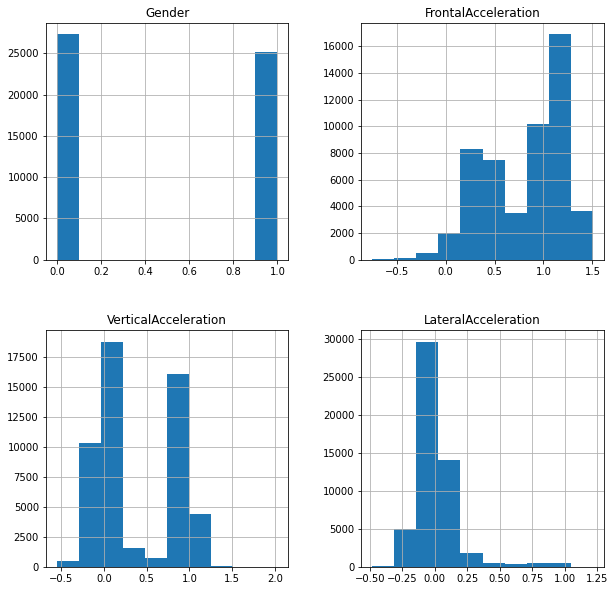

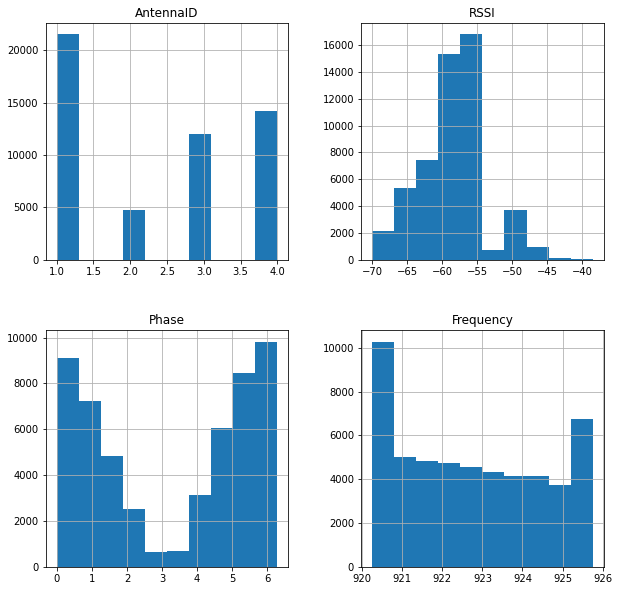

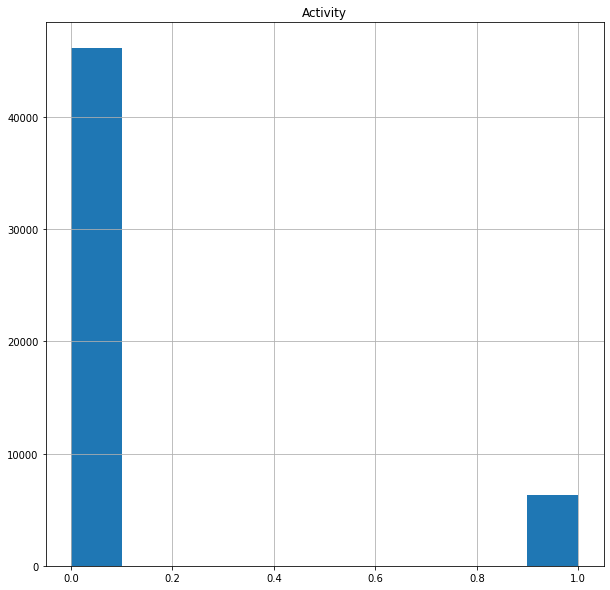

In [22]:
# Get histograms of input and output columns
plt.rcParams["figure.figsize"] = ((10,10))
datasetFrame.hist(column=['Gender', 'FrontalAcceleration', 'VerticalAcceleration', 'LateralAcceleration'], layout=(2,2))
datasetFrame.hist(column=['AntennaID', 'RSSI', 'Phase', 'Frequency'])
datasetFrame.hist(column=['Activity'])

###Data Processing

####Data Splitting

In [23]:
# Split into training and validation
index_percent = int (SPLIT_RATIO * len(dataset[:,0]))
print(index_percent)
XTRAIN = np.copy(dataset[index_percent:, 0:-1])
YTRAIN = np.copy(dataset[index_percent:, -1])
XVALID = np.copy(dataset[:index_percent, 0:-1])
YVALID = np.copy(dataset[:index_percent, -1])

15744


####Data Normalization

In [24]:
# Isolate input from output
Input = np.copy(dataset[:, 0:-1])
print(Input[0:5])

[[ 1.00  0.45  0.93 -0.04  2.00 -56.00  6.28  921.75]
 [ 0.00  0.21  0.99  0.07  4.00 -56.50  0.82  923.25]
 [ 1.00  0.98  0.11 -0.09  1.00 -56.50  1.56  922.75]
 [ 1.00  0.40  0.96 -0.09  3.00 -60.00  4.70  920.25]
 [ 0.00  1.32 -0.03  0.05  4.00 -65.50  0.07  920.75]]


In [25]:
# Find mean and standard deviation of input
xMean = Input.mean(axis=0)
Input -= xMean
xStd = Input.std(axis=0)
Input /= xStd

# Define functions to quickly normalize and revert data
def normalize(arr):
    return (arr - xMean) / xStd

def undoNormalize(arr):
    return (arr * xStd) + xMean

In [26]:
# Normalize training and validation data
XTRAIN = normalize(XTRAIN)
XVALID = normalize(XVALID)
print(XTRAIN)
print(XVALID)

[[ 1.04  0.70 -0.69 ...  0.31  1.31  1.76]
 [-0.96 -1.20  1.27 ... -0.12 -1.09 -0.30]
 [ 1.04  0.31 -0.52 ... -1.42 -1.39 -1.48]
 ...
 [ 1.04  0.73 -0.66 ... -0.67  0.82  0.29]
 [-0.96  0.19  0.83 ... -1.97  0.42 -0.60]
 [ 1.04  0.46 -0.17 ...  0.09  0.84 -0.01]]
[[ 1.04 -0.90  1.17 ...  0.53  1.34 -0.60]
 [-0.96 -1.49  1.30 ...  0.42 -1.10  0.29]
 [ 1.04  0.43 -0.57 ...  0.42 -0.77 -0.01]
 ...
 [-0.96 -2.65  1.22 ...  1.94  0.32 -0.60]
 [-0.96 -1.55  1.32 ... -0.34 -1.39  1.17]
 [-0.96 -1.79  1.30 ...  0.20 -0.86 -1.48]]


##Modelling

### Architecture

Architecture code found in [Project Phase II](https://colab.research.google.com/drive/192pLs5ynLb3A_wMtMOt_4ykyHXqnrFvi?usp=sharing).

### Hyperparameters

**Potential Hyper-Parameters to Test**
<br>training = (XTRAIN, YTRAIN)
<br>validation = (XVALID, YVALID)
<br>layersArr = [1, 2, 4, 8, 16]
<br>neuronsArr = [2, 4, 8, 16, 32]
<br>activationsArr = ['sigmoid', 'linear', 'relu', 'elu']
<br>optimizationsArr = ['rmsprop', 'sgd', 'nadam', 'adam', 'ftrl']
<br>batchSizesArr = [8, 16, 32, 64]
<br>epochsArr = [8, 16, 32, 64, 128, 256, 512]

#### 3-Layer Sigmoid Activation

Testing 48 sets of hyperparameters.

Progress: [####################] 100.00% Done...

------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.10%
  Precision: 98.19%
  Recall: 85.83%
  F1-score: 0.92
  Validation Accuracy: 98.32%



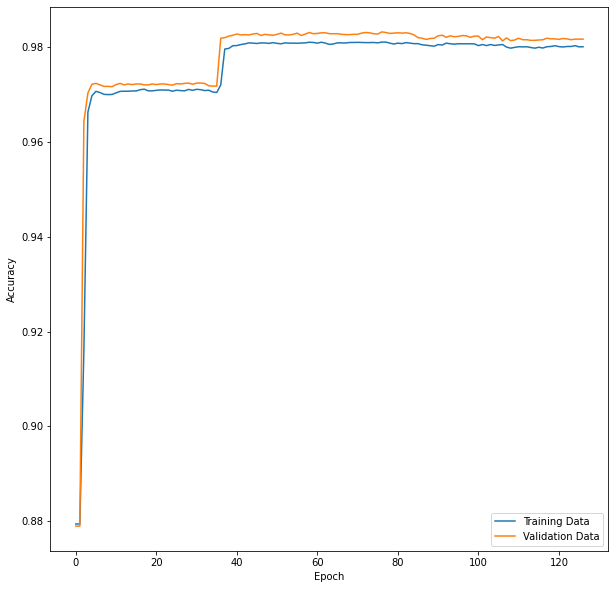

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.11%
  Precision: 97.82%
  Recall: 86.28%
  F1-score: 0.92
  Validation Accuracy: 98.32%



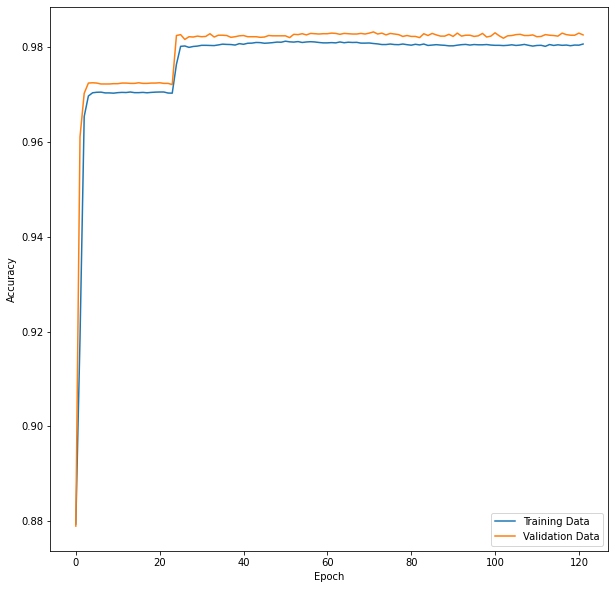

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.16%
  Precision: 98.58%
  Recall: 85.96%
  F1-score: 0.92
  Validation Accuracy: 98.34%



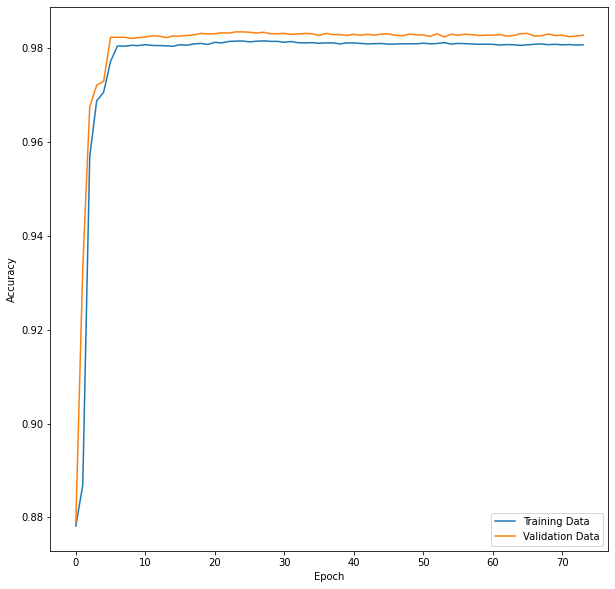

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.17%
  Precision: 98.75%
  Recall: 85.87%
  F1-score: 0.92
  Validation Accuracy: 98.39%



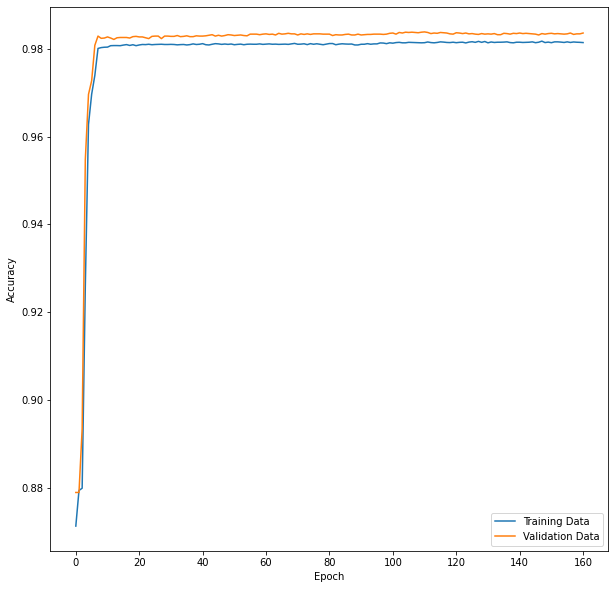

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  256

Predictions:
  Accuracy: 98.18%
  Precision: 98.73%
  Recall: 86.03%
  F1-score: 0.92
  Validation Accuracy: 98.42%



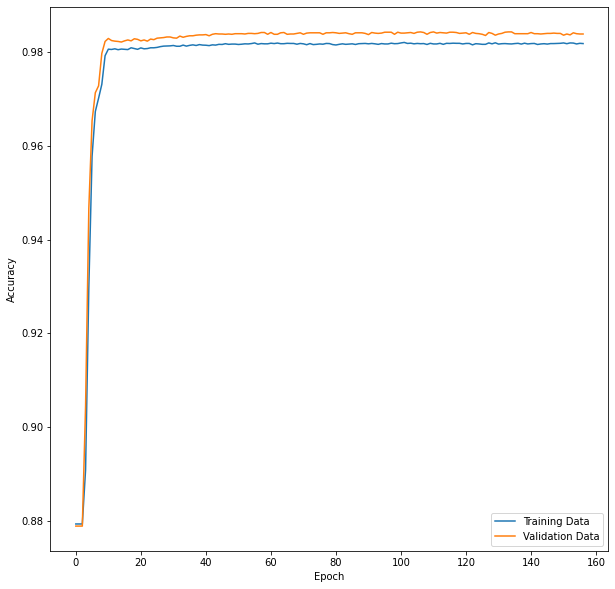

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  512

Predictions:
  Accuracy: 98.19%
  Precision: 98.56%
  Recall: 86.23%
  F1-score: 0.92
  Validation Accuracy: 98.41%



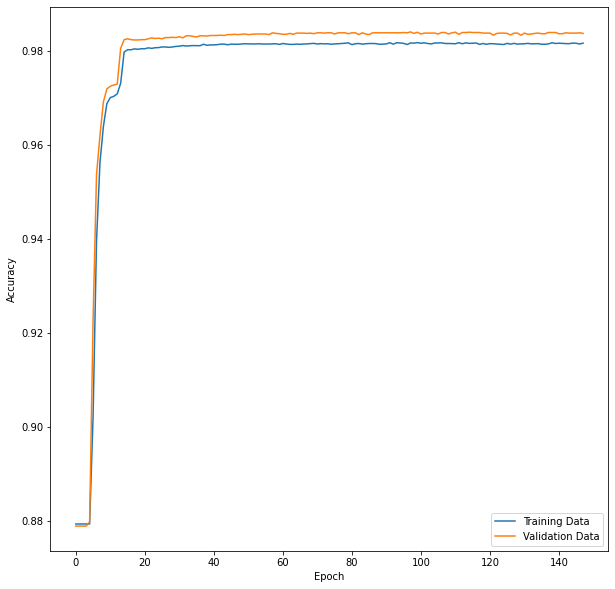

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  1024

Predictions:
  Accuracy: 98.16%
  Precision: 98.53%
  Recall: 86.03%
  F1-score: 0.92
  Validation Accuracy: 98.33%



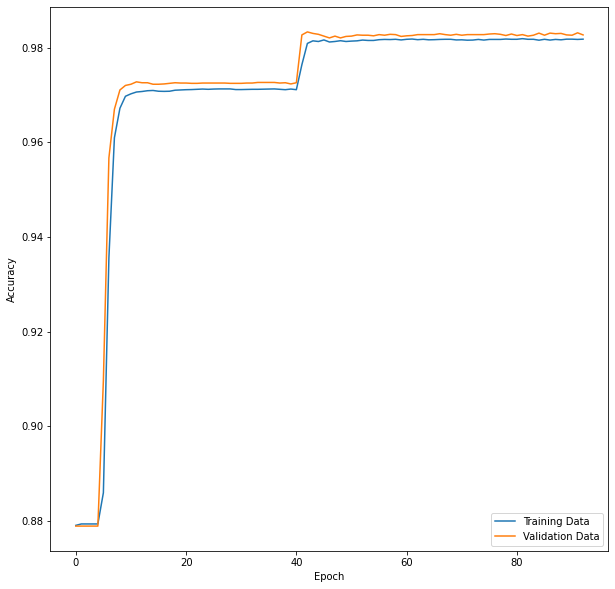

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  512

Predictions:
  Accuracy: 98.12%
  Precision: 98.27%
  Recall: 85.94%
  F1-score: 0.92
  Validation Accuracy: 98.34%



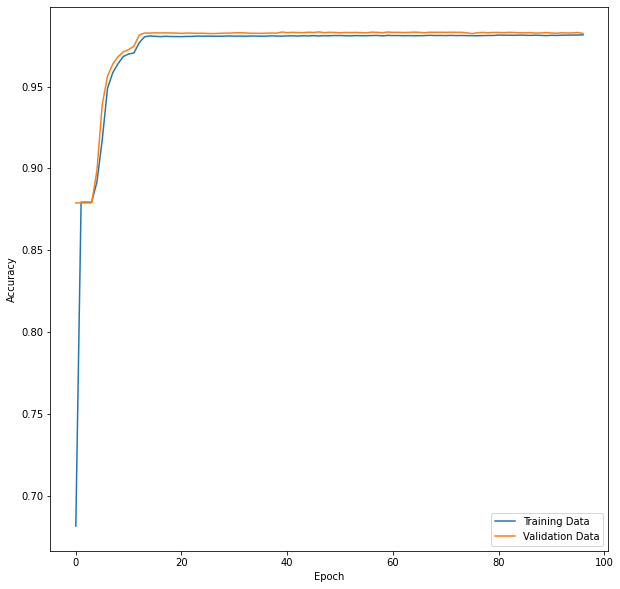

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  1024

Predictions:
  Accuracy: 98.17%
  Precision: 98.15%
  Recall: 86.44%
  F1-score: 0.92
  Validation Accuracy: 98.41%



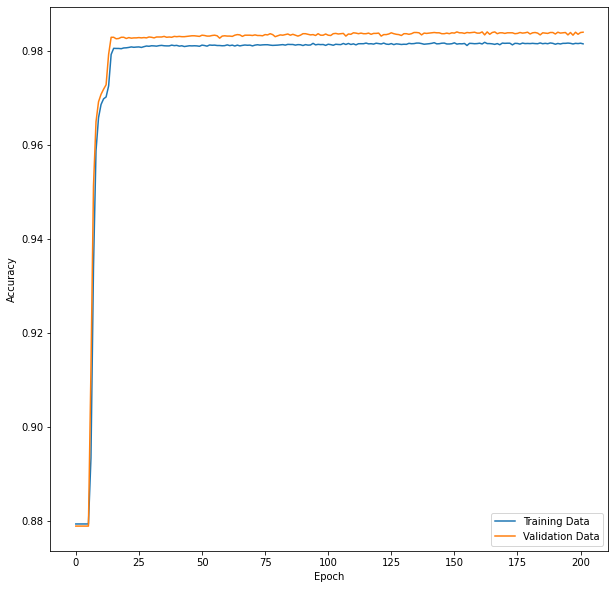

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.12%
  Precision: 98.20%
  Recall: 86.03%
  F1-score: 0.92
  Validation Accuracy: 98.34%



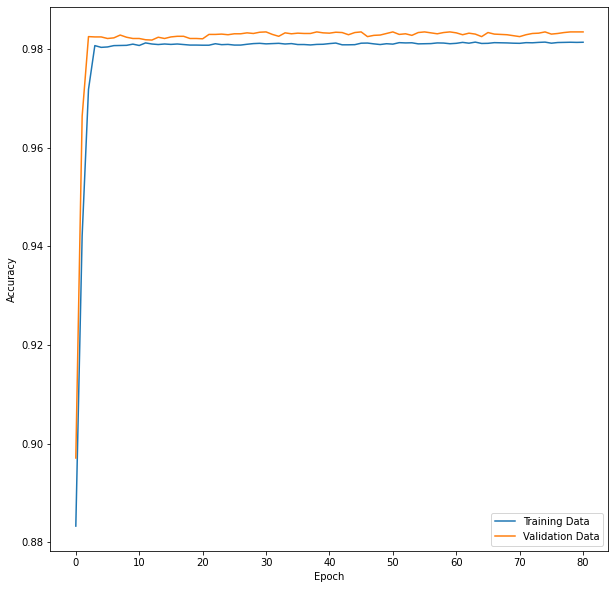

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.17%
  Precision: 98.45%
  Recall: 86.21%
  F1-score: 0.92
  Validation Accuracy: 98.38%



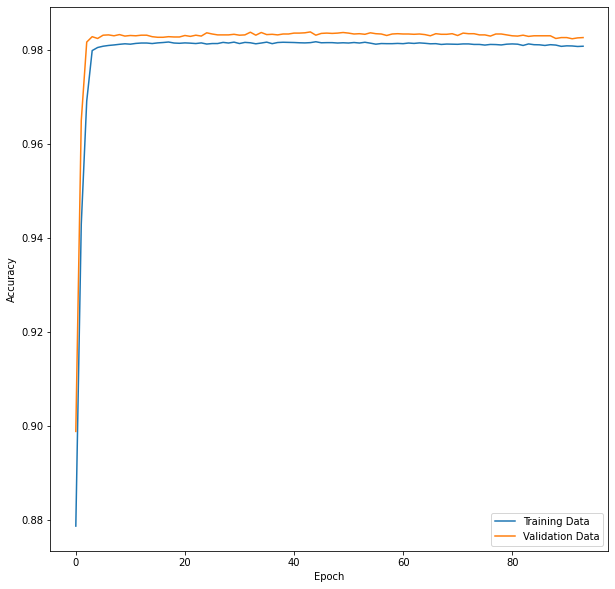

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.19%
  Precision: 98.63%
  Recall: 86.21%
  F1-score: 0.92
  Validation Accuracy: 98.36%



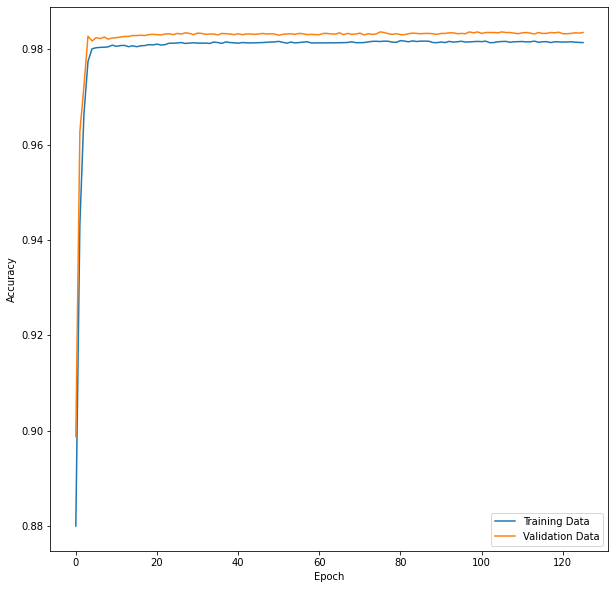

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  256

Predictions:
  Accuracy: 98.28%
  Precision: 98.22%
  Recall: 87.29%
  F1-score: 0.92
  Validation Accuracy: 98.42%



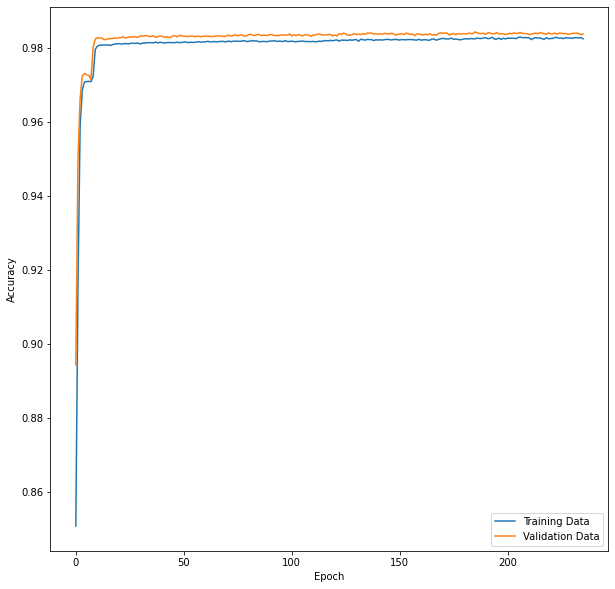

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  512

Predictions:
  Accuracy: 98.21%
  Precision: 98.31%
  Recall: 86.64%
  F1-score: 0.92
  Validation Accuracy: 98.39%



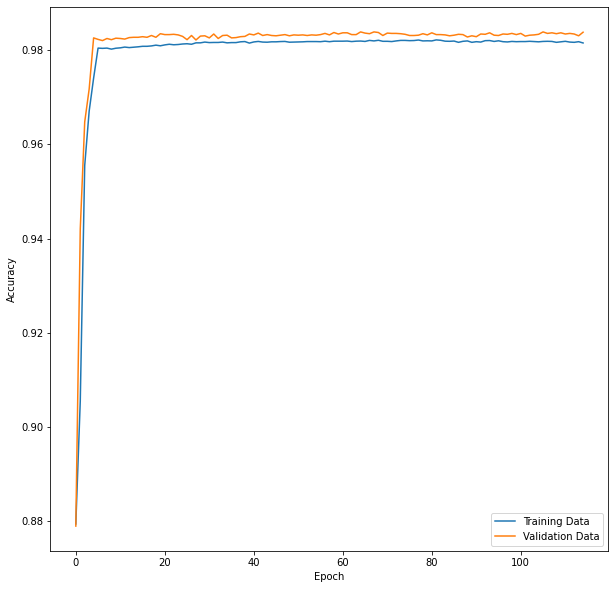

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.27%
  Precision: 98.69%
  Recall: 86.84%
  F1-score: 0.92
  Validation Accuracy: 98.47%



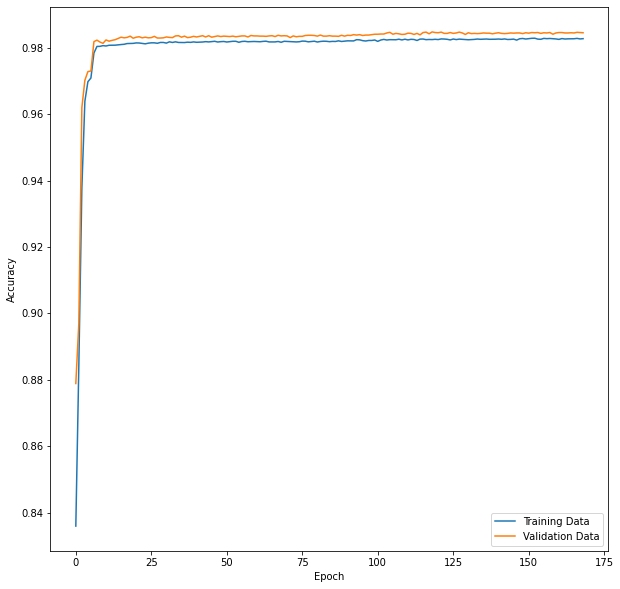

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  256

Predictions:
  Accuracy: 98.36%
  Precision: 98.48%
  Recall: 87.72%
  F1-score: 0.93
  Validation Accuracy: 98.53%



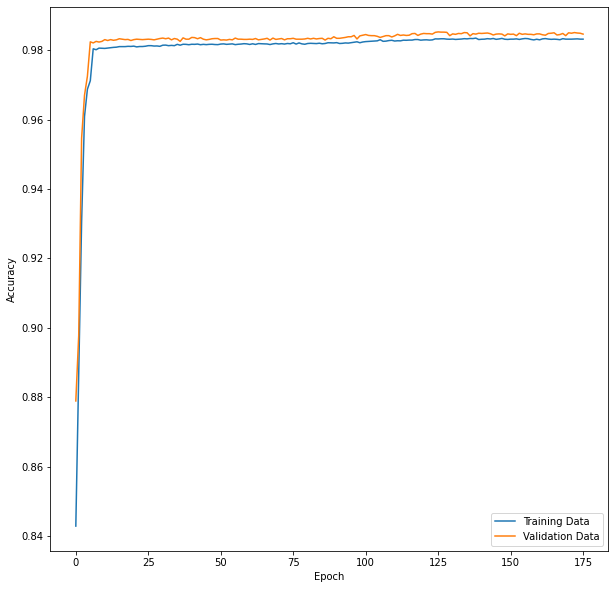

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  512

Predictions:
  Accuracy: 98.40%
  Precision: 98.00%
  Recall: 88.54%
  F1-score: 0.93
  Validation Accuracy: 98.51%



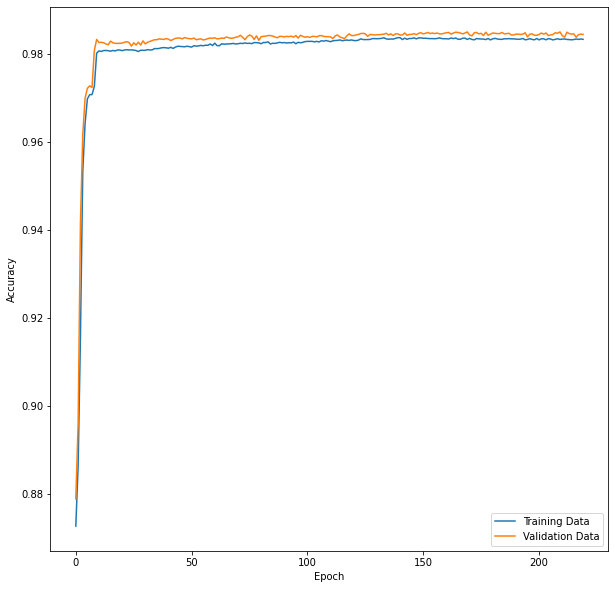

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  1024

Predictions:
  Accuracy: 98.18%
  Precision: 98.23%
  Recall: 86.44%
  F1-score: 0.92
  Validation Accuracy: 98.41%



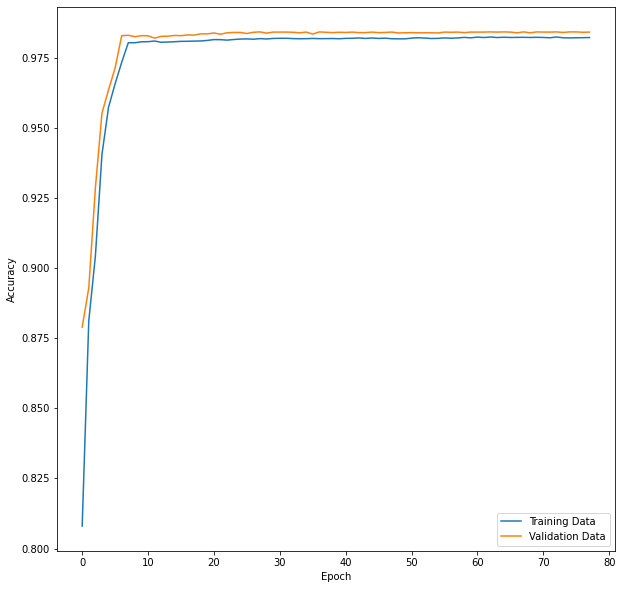

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  256

Predictions:
  Accuracy: 98.35%
  Precision: 97.68%
  Recall: 88.40%
  F1-score: 0.93
  Validation Accuracy: 98.53%



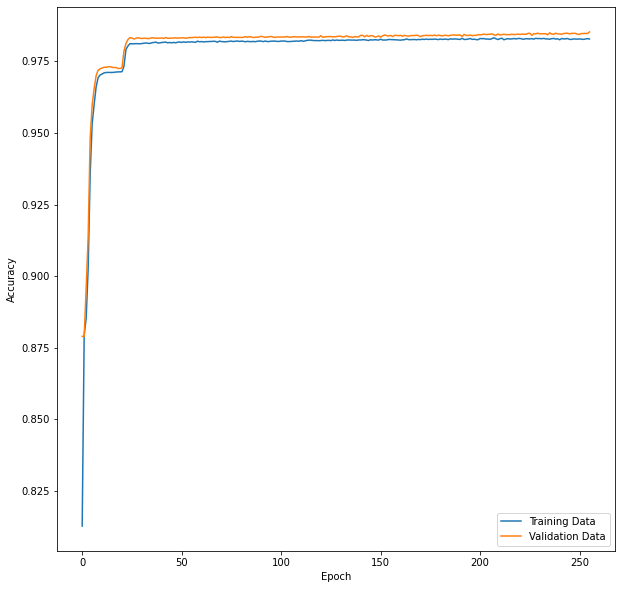

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  512

Predictions:
  Accuracy: 98.17%
  Precision: 98.40%
  Recall: 86.23%
  F1-score: 0.92
  Validation Accuracy: 98.42%



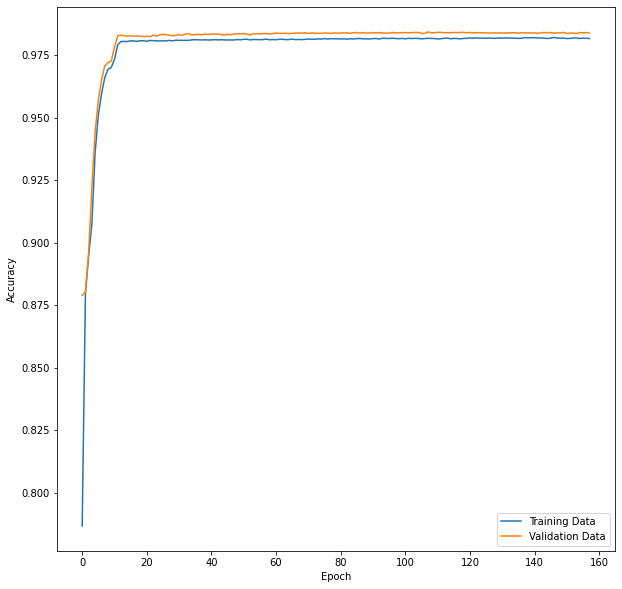

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  1024

Predictions:
  Accuracy: 98.26%
  Precision: 98.27%
  Recall: 87.11%
  F1-score: 0.92
  Validation Accuracy: 98.43%



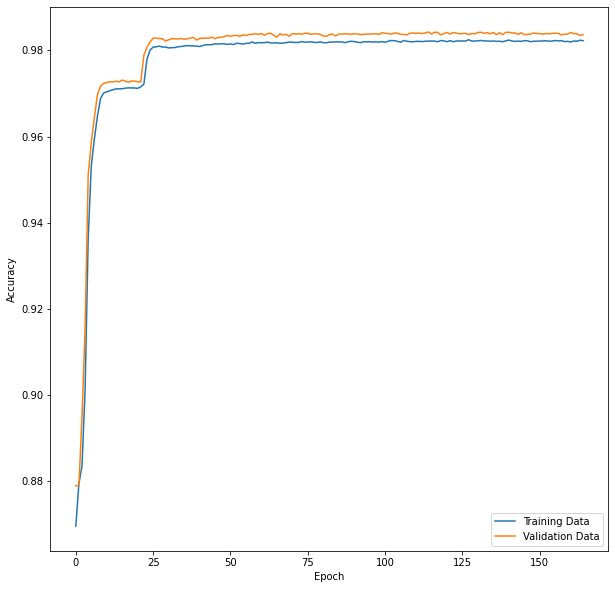

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.17%
  Precision: 97.69%
  Recall: 86.84%
  F1-score: 0.92
  Validation Accuracy: 98.44%



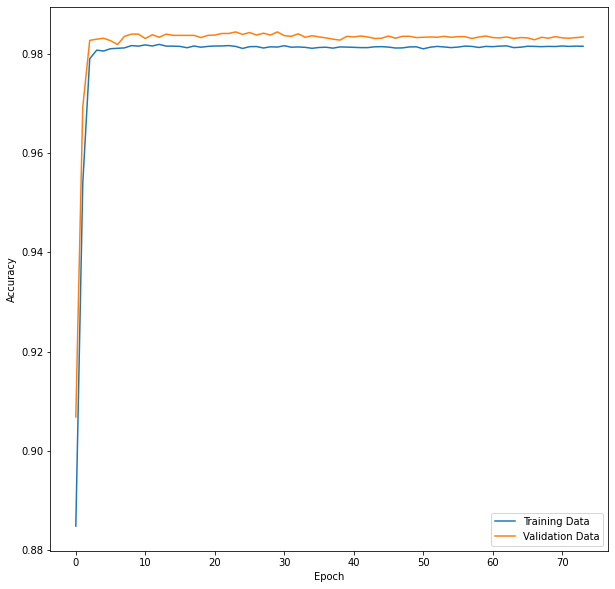

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.18%
  Precision: 98.38%
  Recall: 86.37%
  F1-score: 0.92
  Validation Accuracy: 98.39%



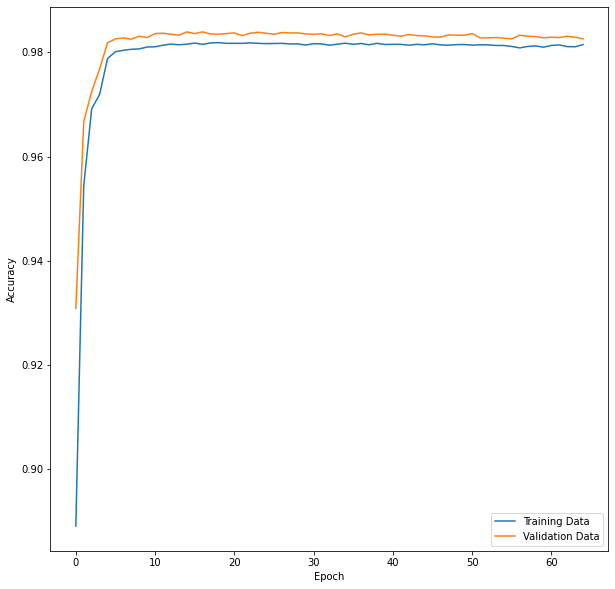

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.20%
  Precision: 98.28%
  Recall: 86.55%
  F1-score: 0.92
  Validation Accuracy: 98.41%



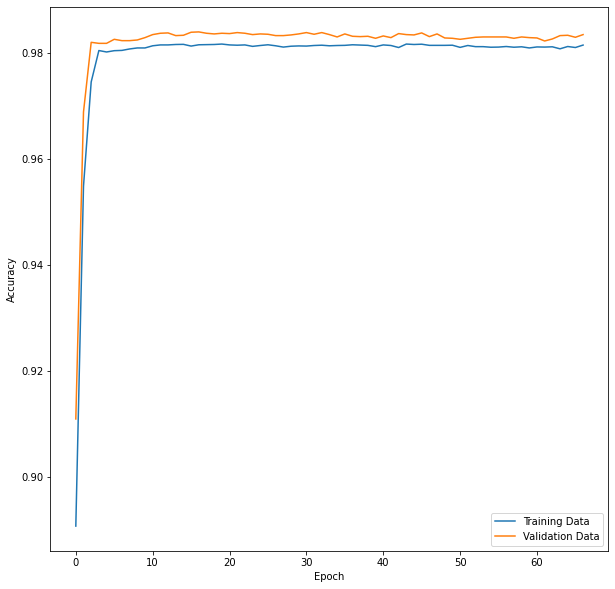

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  256

Predictions:
  Accuracy: 98.26%
  Precision: 98.22%
  Recall: 87.14%
  F1-score: 0.92
  Validation Accuracy: 98.46%



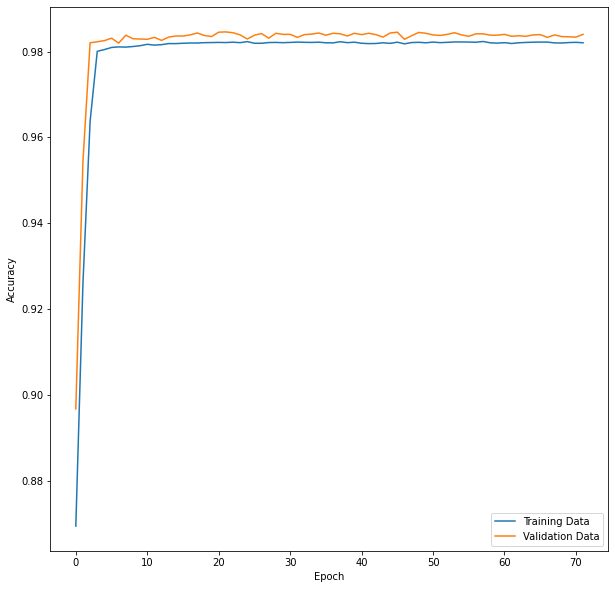

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  512

Predictions:
  Accuracy: 98.41%
  Precision: 98.05%
  Recall: 88.58%
  F1-score: 0.93
  Validation Accuracy: 98.53%



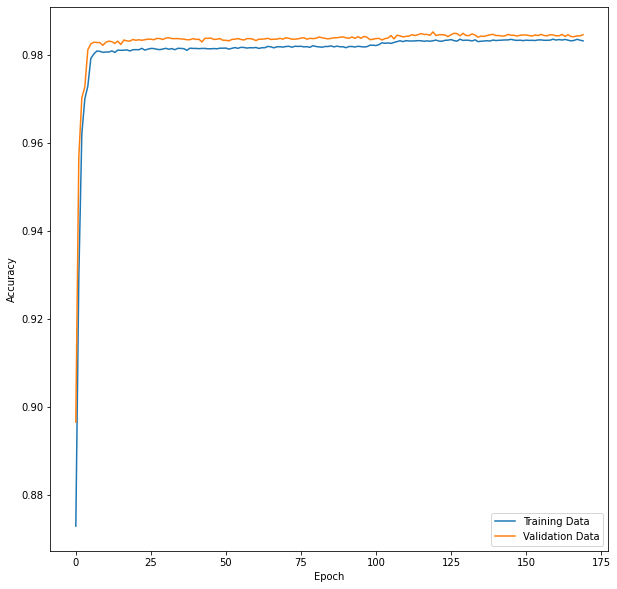

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.53%
  Precision: 97.21%
  Recall: 90.43%
  F1-score: 0.94
  Validation Accuracy: 98.69%



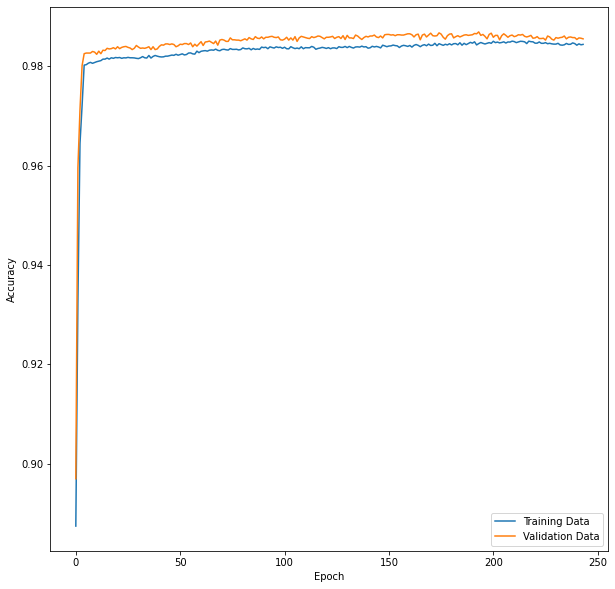

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  256

Predictions:
  Accuracy: 98.47%
  Precision: 98.40%
  Recall: 88.74%
  F1-score: 0.93
  Validation Accuracy: 98.62%



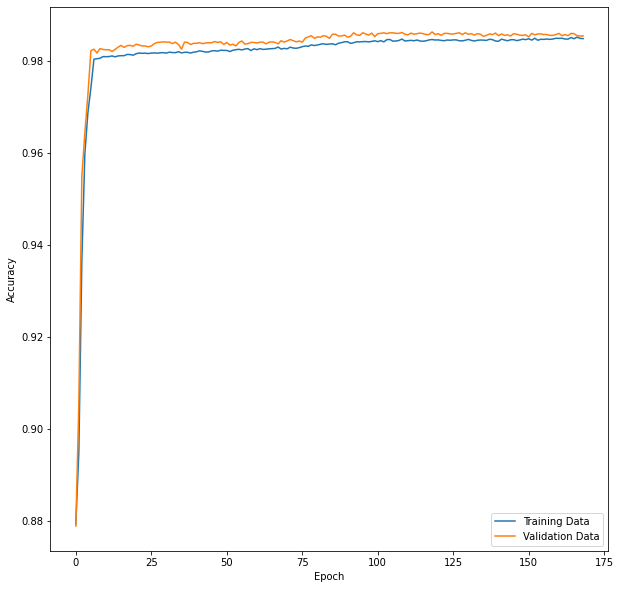

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  512

Predictions:
  Accuracy: 98.30%
  Precision: 98.67%
  Recall: 87.07%
  F1-score: 0.93
  Validation Accuracy: 98.49%



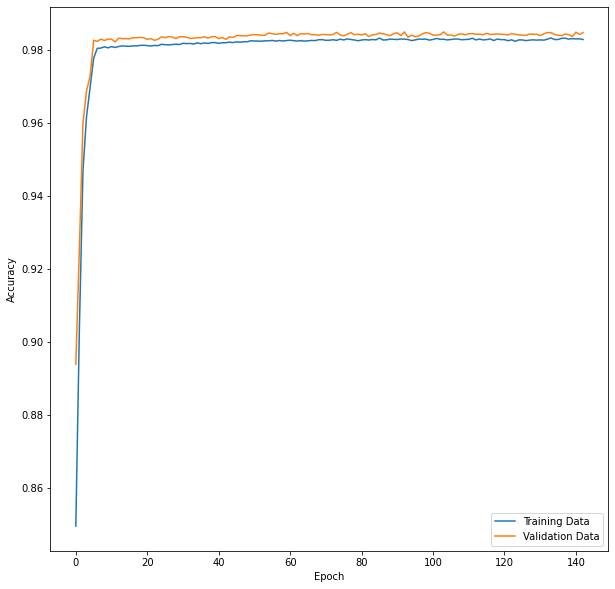

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  32
Epochs:  1024

Predictions:
  Accuracy: 98.33%
  Precision: 98.60%
  Recall: 87.41%
  F1-score: 0.93
  Validation Accuracy: 98.52%



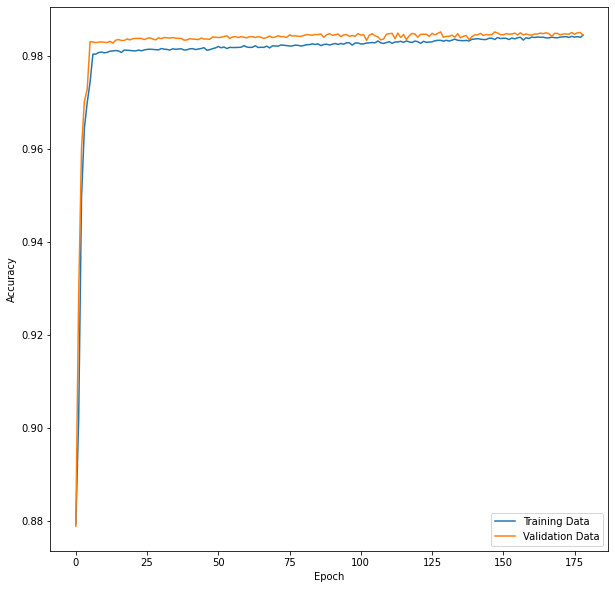

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  256

Predictions:
  Accuracy: 98.25%
  Precision: 97.97%
  Recall: 87.27%
  F1-score: 0.92
  Validation Accuracy: 98.43%



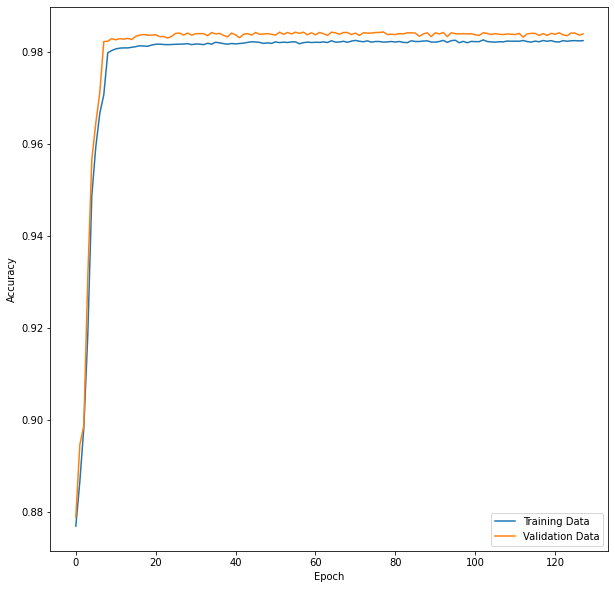

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  512

Predictions:
  Accuracy: 98.22%
  Precision: 97.97%
  Recall: 87.02%
  F1-score: 0.92
  Validation Accuracy: 98.38%



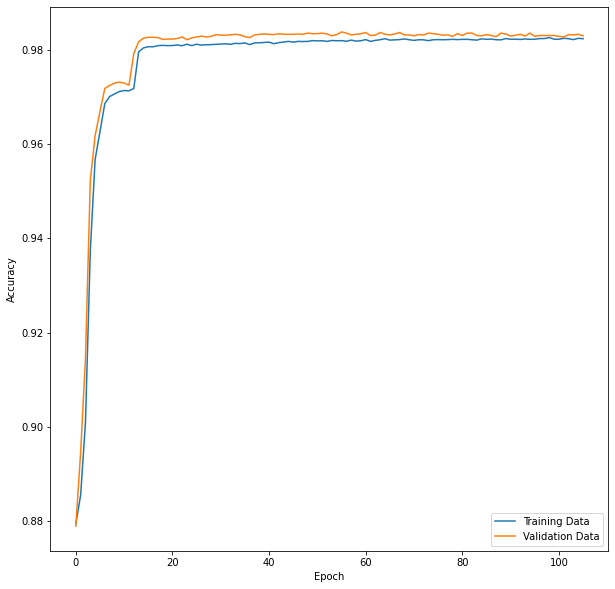

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  64
Epochs:  1024

Predictions:
  Accuracy: 98.62%
  Precision: 98.18%
  Recall: 90.21%
  F1-score: 0.94
  Validation Accuracy: 98.66%



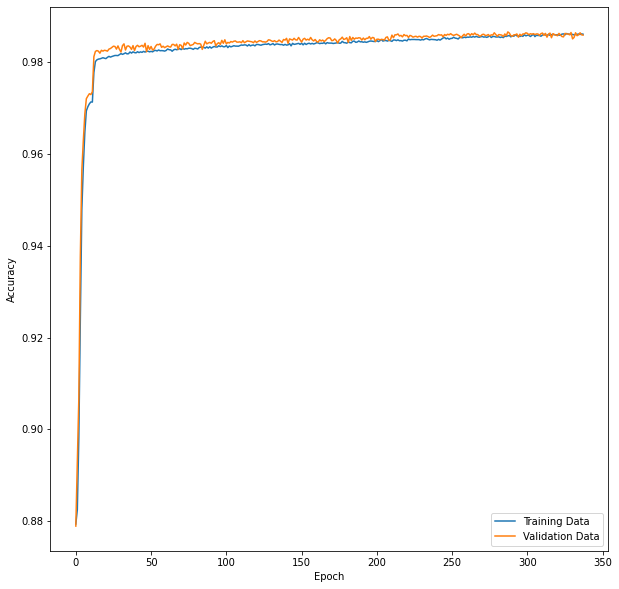

------------------------------------


----- 'Best' Hyperparamaters -----
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  rmsprop
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.53%
  Precision: 97.21%
  Recall: 90.43%
  F1-score: 0.94
  Validation Accuracy: 98.69%



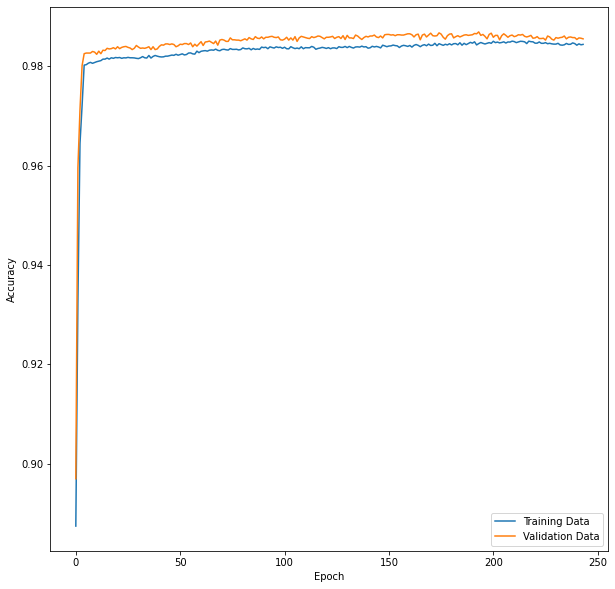

In [28]:
# 3-layered / sigmoid / rmsprop
training = (XTRAIN, YTRAIN)
validation = (XVALID, YVALID)
layersArr = [3]
neuronsArr = [2, 4, 8, 16]
activationsArr = ['sigmoid']
optimizationsArr = ['rmsprop']
batchSizesArr = [8, 16, 32, 64]
epochsArr = [256, 512, 1024]

bestHyperparameters = optimize_hyperparameters_acc(training, validation, layersArr, neuronsArr, activationsArr, optimizationsArr, batchSizesArr, epochsArr)

Testing 48 sets of hyperparameters.

Progress: [####################] 100.00% Done...

------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.21%
  Precision: 97.65%
  Recall: 87.23%
  F1-score: 0.92
  Validation Accuracy: 98.41%



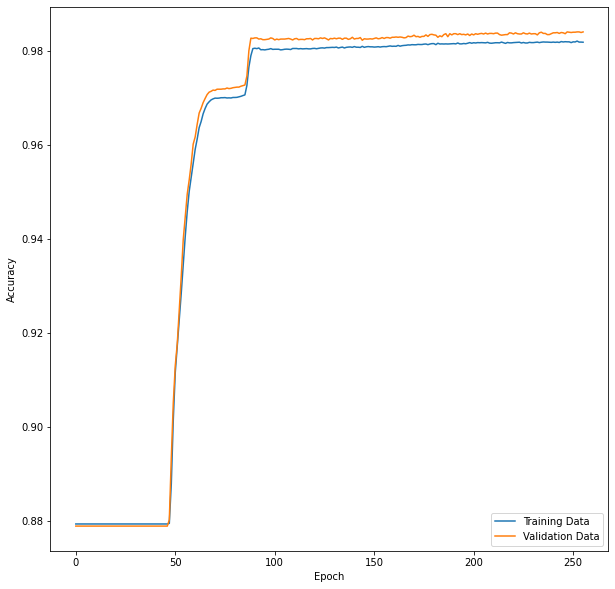

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.09%
  Precision: 98.44%
  Recall: 85.53%
  F1-score: 0.92
  Validation Accuracy: 98.34%



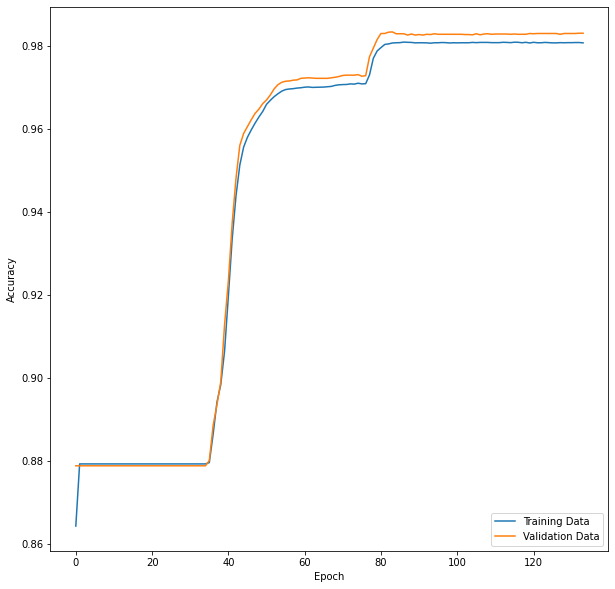

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.16%
  Precision: 98.20%
  Recall: 86.30%
  F1-score: 0.92
  Validation Accuracy: 98.43%



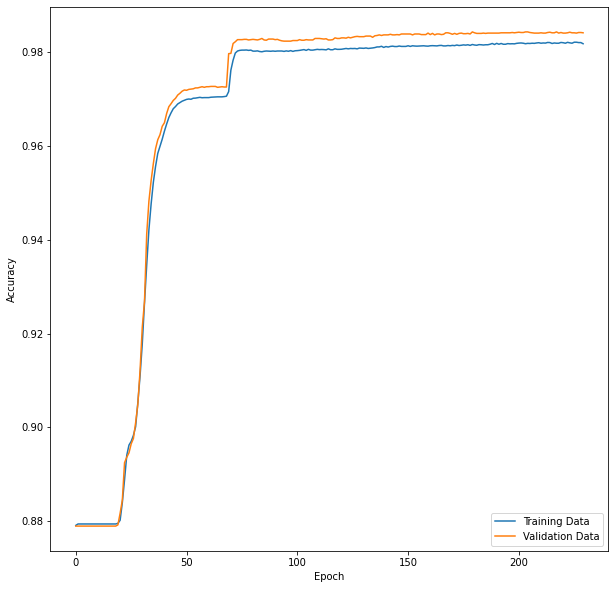

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.12%
  Precision: 97.75%
  Recall: 86.41%
  F1-score: 0.92
  Validation Accuracy: 98.37%



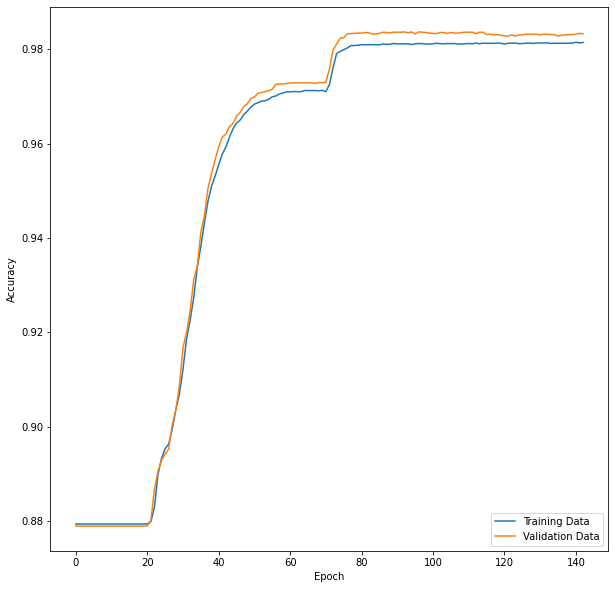

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.08%
  Precision: 98.04%
  Recall: 85.76%
  F1-score: 0.91
  Validation Accuracy: 98.32%



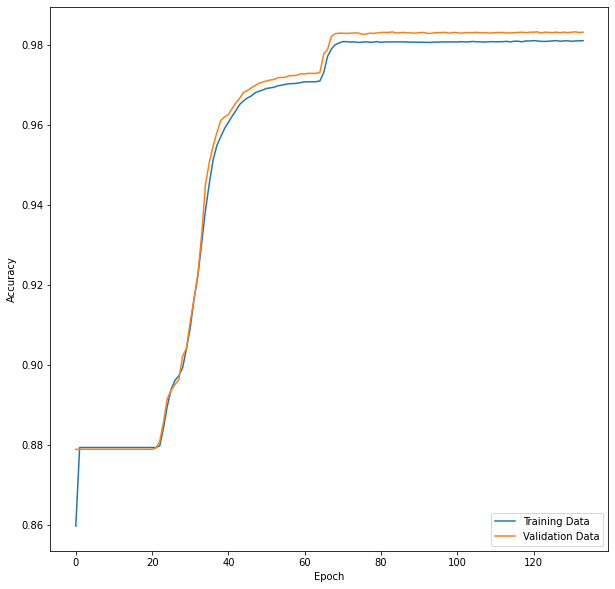

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  sgd
Batch Size:  16
Epochs:  256

Predictions:
  Accuracy: 98.07%
  Precision: 98.87%
  Recall: 84.99%
  F1-score: 0.91
  Validation Accuracy: 98.31%



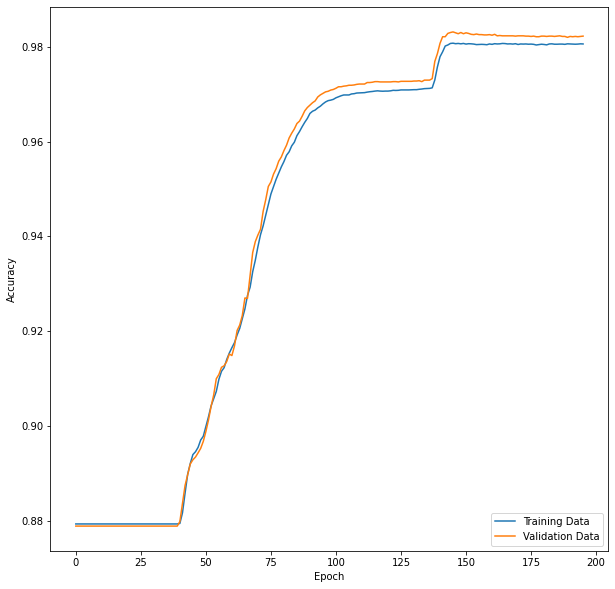

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  sgd
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.17%
  Precision: 97.84%
  Recall: 86.71%
  F1-score: 0.92
  Validation Accuracy: 98.36%



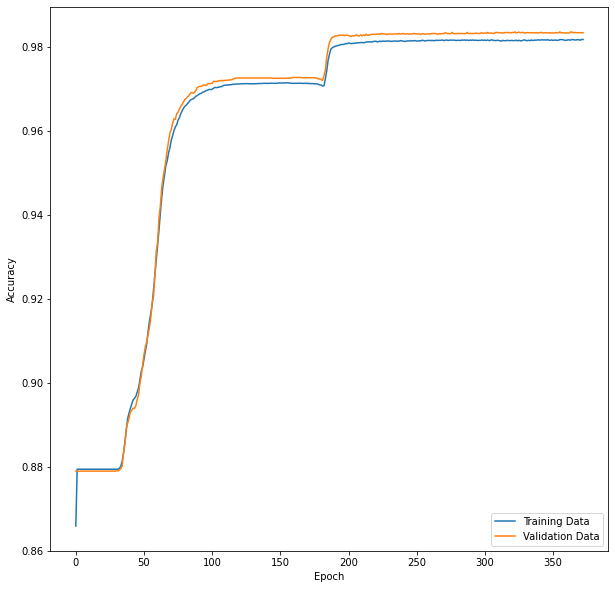

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.18%
  Precision: 98.33%
  Recall: 86.37%
  F1-score: 0.92
  Validation Accuracy: 98.40%



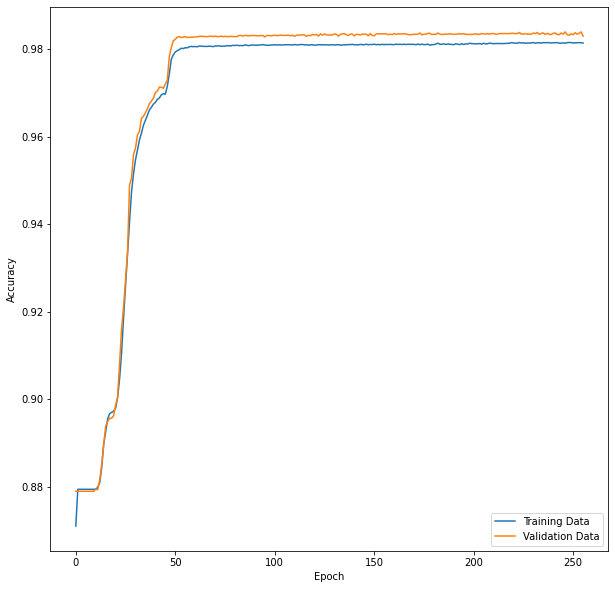

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.20%
  Precision: 98.16%
  Recall: 86.71%
  F1-score: 0.92
  Validation Accuracy: 98.38%



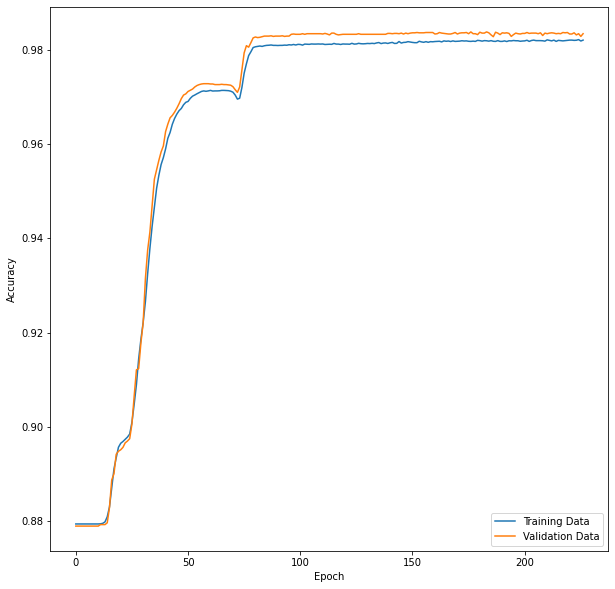

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.26%
  Precision: 98.10%
  Recall: 87.25%
  F1-score: 0.92
  Validation Accuracy: 98.48%



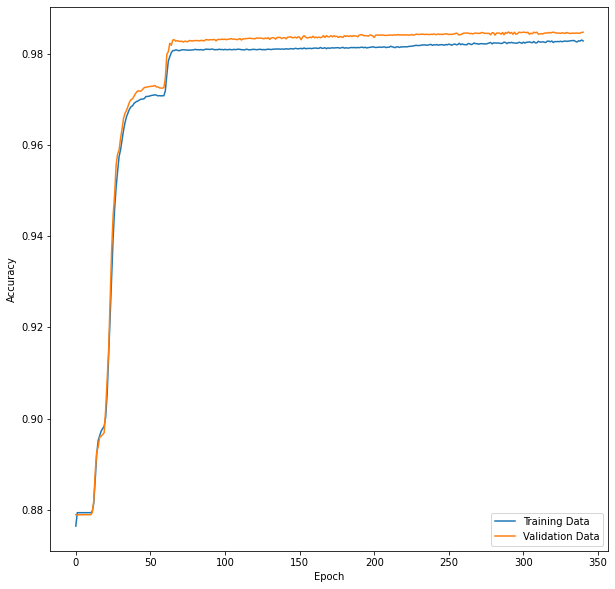

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  sgd
Batch Size:  16
Epochs:  512

Predictions:
  Accuracy: 98.14%
  Precision: 98.00%
  Recall: 86.30%
  F1-score: 0.92
  Validation Accuracy: 98.38%



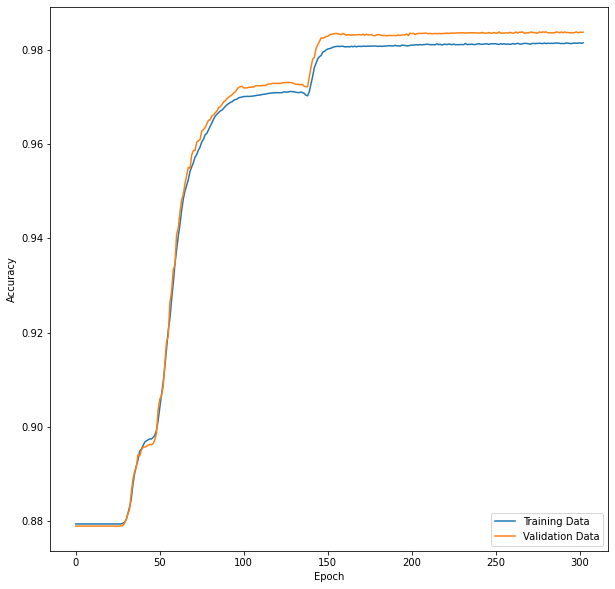

------------------------------------


----- 'Best' Hyperparamaters -----
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  sgd
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.26%
  Precision: 98.10%
  Recall: 87.25%
  F1-score: 0.92
  Validation Accuracy: 98.48%



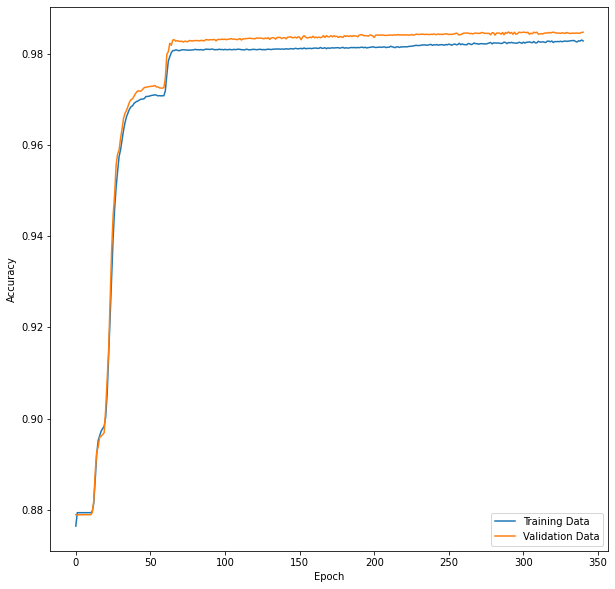

In [29]:
# 3-layered / sigmoid / sgd
training = (XTRAIN, YTRAIN)
validation = (XVALID, YVALID)
layersArr = [3]
neuronsArr = [2, 4, 8, 16]
activationsArr = ['sigmoid']
optimizationsArr = ['sgd']
batchSizesArr = [8, 16, 32, 64]
epochsArr = [256, 512, 1024]

bestHyperparameters = optimize_hyperparameters_acc(training, validation, layersArr, neuronsArr, activationsArr, optimizationsArr, batchSizesArr, epochsArr)

Testing 48 sets of hyperparameters.

Progress: [####################] 100.00% Done...

------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.41%
  Precision: 98.43%
  Recall: 88.34%
  F1-score: 0.93
  Validation Accuracy: 98.34%



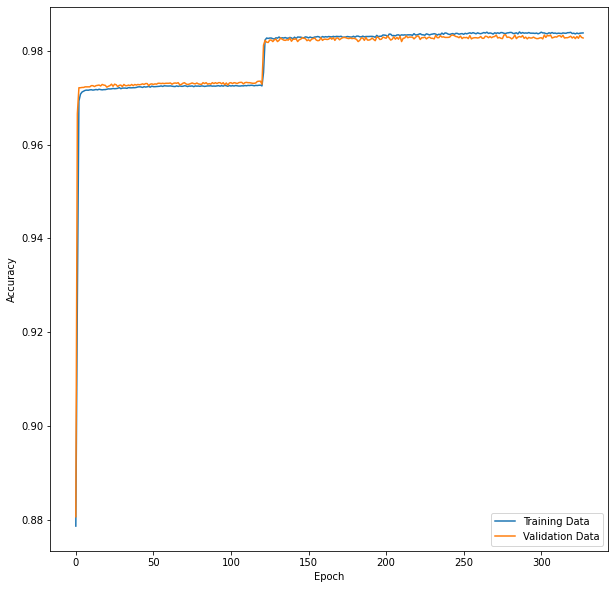

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  256

Predictions:
  Accuracy: 98.38%
  Precision: 98.13%
  Recall: 88.31%
  F1-score: 0.93
  Validation Accuracy: 98.38%



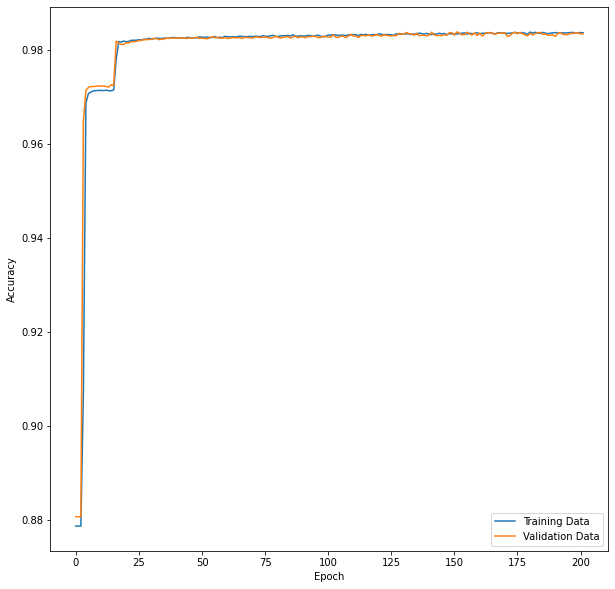

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.35%
  Precision: 97.91%
  Recall: 88.29%
  F1-score: 0.93
  Validation Accuracy: 98.34%



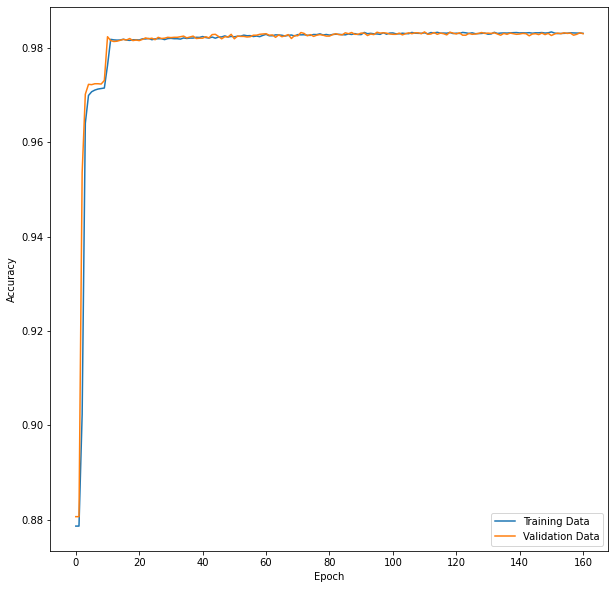

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  1024

Predictions:
  Accuracy: 98.36%
  Precision: 98.42%
  Recall: 87.93%
  F1-score: 0.93
  Validation Accuracy: 98.39%



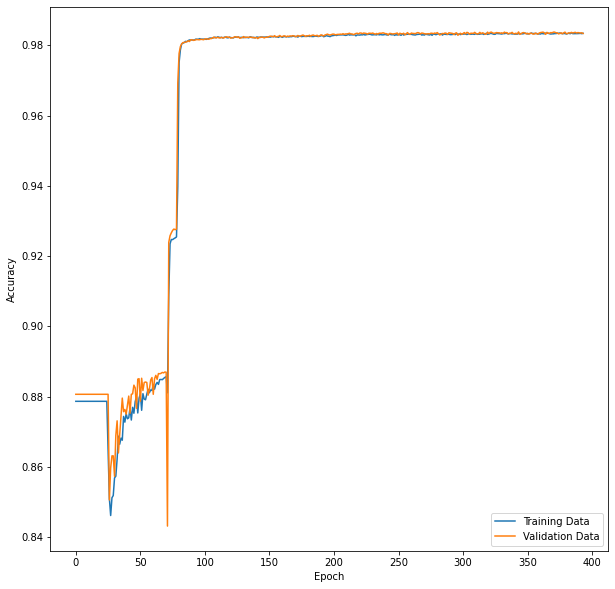

------------------------------------


------------------------------------
Layers:  3
Neurons:  4
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  256

Predictions:
  Accuracy: 98.32%
  Precision: 98.29%
  Recall: 87.66%
  F1-score: 0.93
  Validation Accuracy: 98.27%



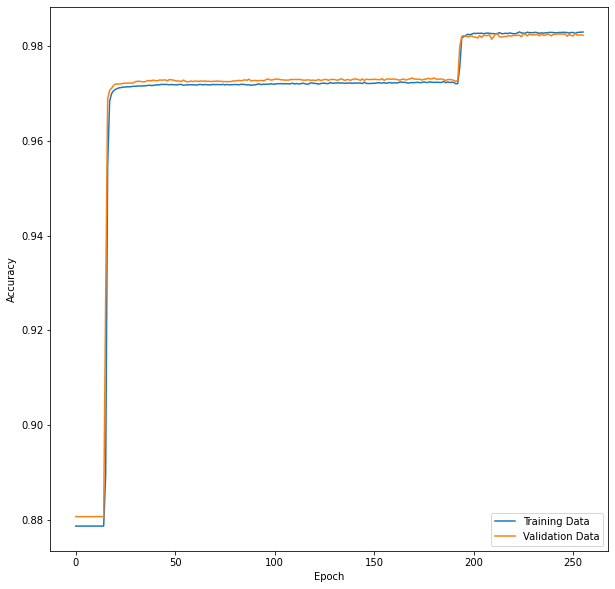

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.43%
  Precision: 98.07%
  Recall: 88.78%
  F1-score: 0.93
  Validation Accuracy: 98.46%



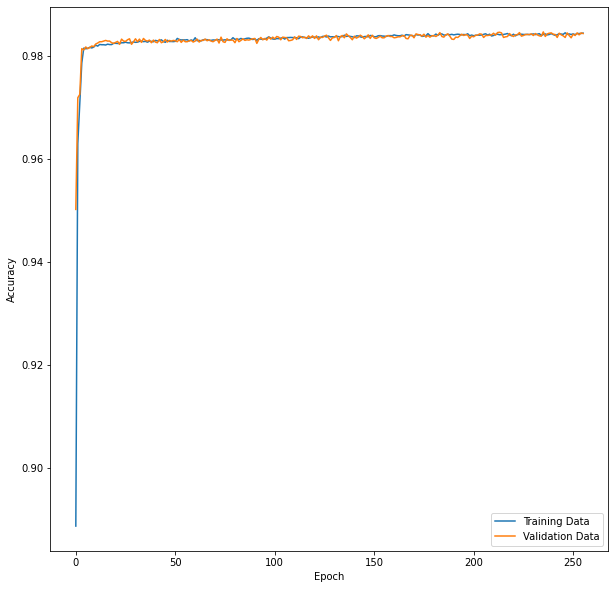

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.46%
  Precision: 98.51%
  Recall: 88.69%
  F1-score: 0.93
  Validation Accuracy: 98.44%



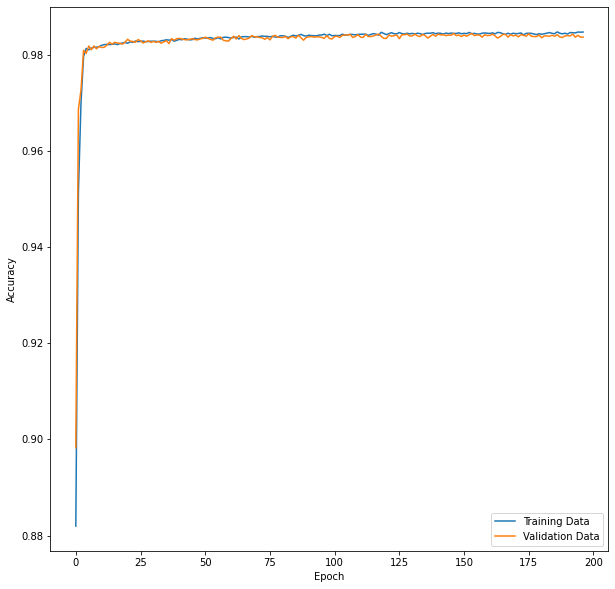

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 98.54%
  Precision: 97.95%
  Recall: 89.82%
  F1-score: 0.94
  Validation Accuracy: 98.48%



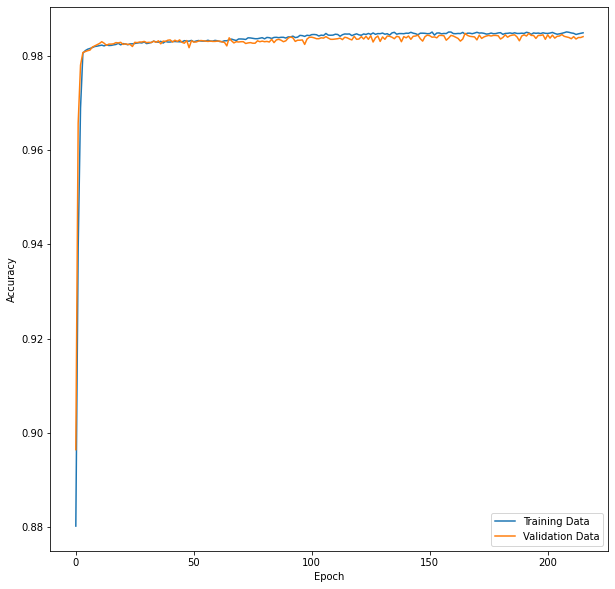

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  256

Predictions:
  Accuracy: 98.49%
  Precision: 98.58%
  Recall: 88.83%
  F1-score: 0.93
  Validation Accuracy: 98.44%



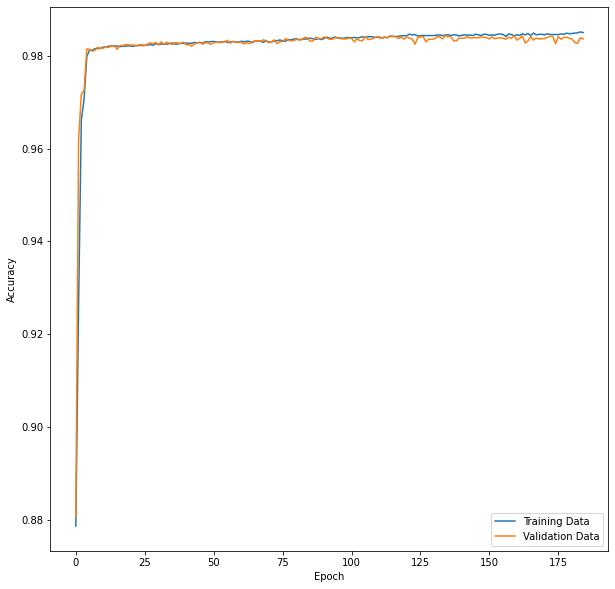

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  512

Predictions:
  Accuracy: 98.43%
  Precision: 98.31%
  Recall: 88.58%
  F1-score: 0.93
  Validation Accuracy: 98.40%



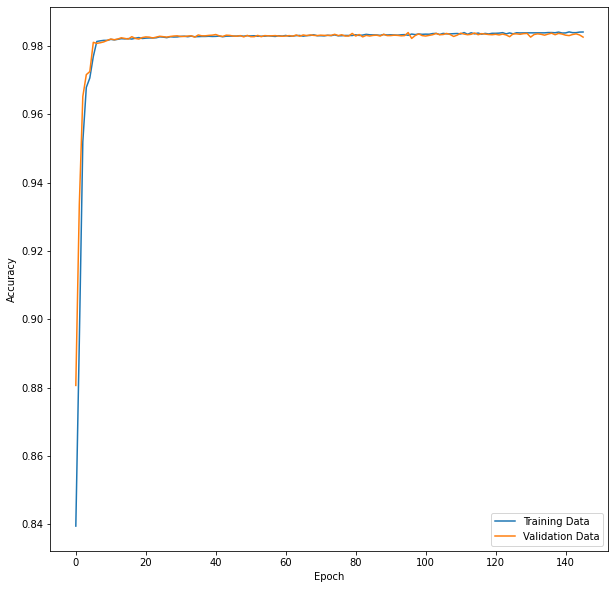

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.43%
  Precision: 98.45%
  Recall: 88.47%
  F1-score: 0.93
  Validation Accuracy: 98.41%



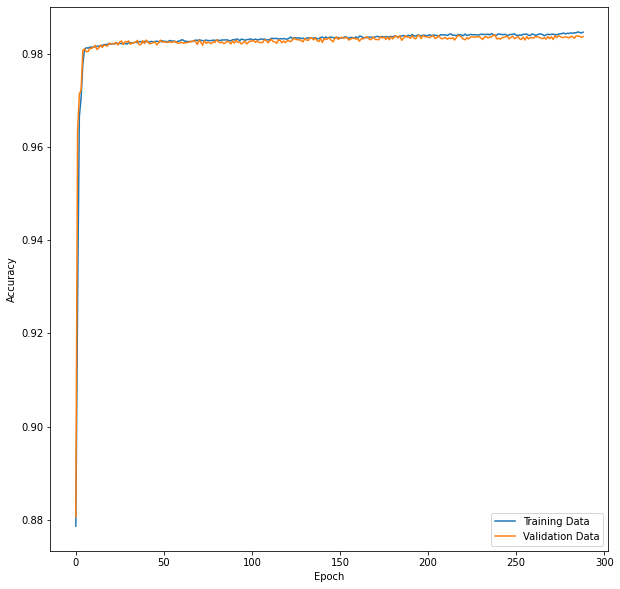

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  256

Predictions:
  Accuracy: 98.60%
  Precision: 98.71%
  Recall: 89.59%
  F1-score: 0.94
  Validation Accuracy: 98.54%



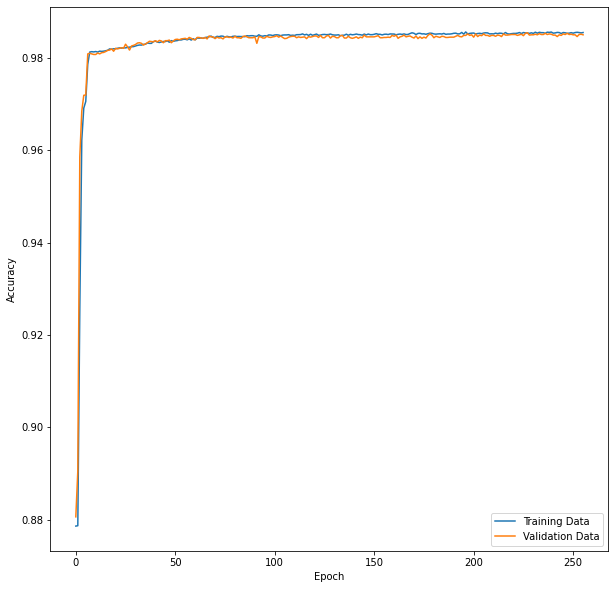

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  512

Predictions:
  Accuracy: 98.62%
  Precision: 98.48%
  Recall: 90.00%
  F1-score: 0.94
  Validation Accuracy: 98.52%



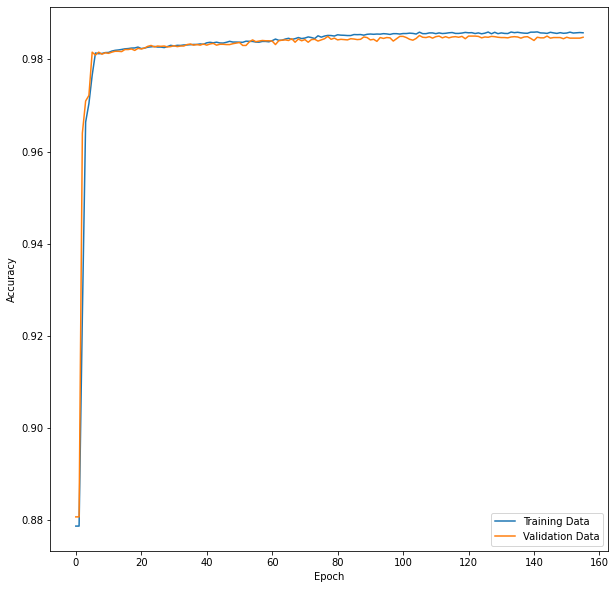

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  1024

Predictions:
  Accuracy: 98.35%
  Precision: 98.44%
  Recall: 87.82%
  F1-score: 0.93
  Validation Accuracy: 98.37%



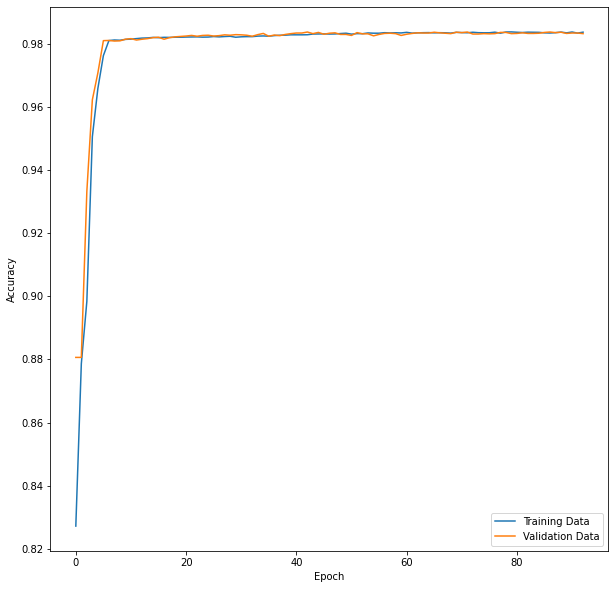

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  256

Predictions:
  Accuracy: 98.45%
  Precision: 98.77%
  Recall: 88.36%
  F1-score: 0.93
  Validation Accuracy: 98.45%



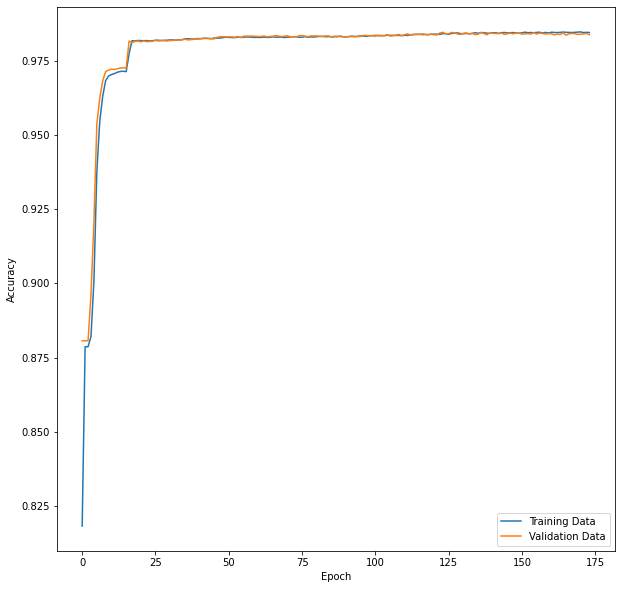

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  512

Predictions:
  Accuracy: 98.47%
  Precision: 98.07%
  Recall: 89.12%
  F1-score: 0.93
  Validation Accuracy: 98.45%



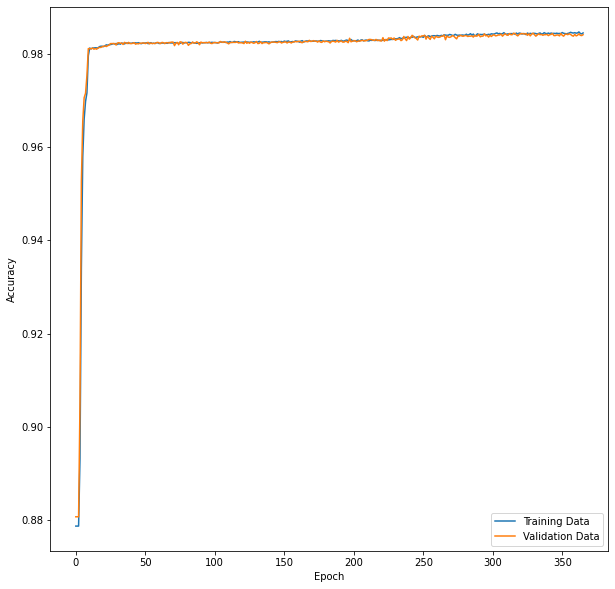

------------------------------------


------------------------------------
Layers:  3
Neurons:  8
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  1024

Predictions:
  Accuracy: 98.29%
  Precision: 98.26%
  Recall: 87.48%
  F1-score: 0.93
  Validation Accuracy: 98.34%



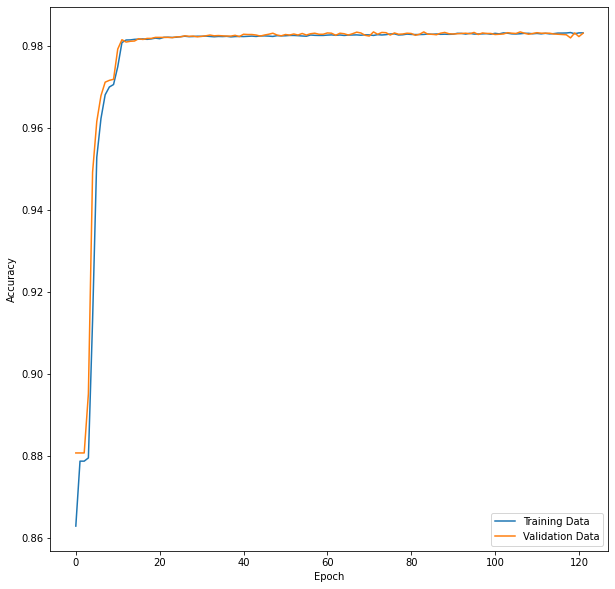

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  256

Predictions:
  Accuracy: 98.81%
  Precision: 99.00%
  Recall: 91.07%
  F1-score: 0.95
  Validation Accuracy: 98.71%



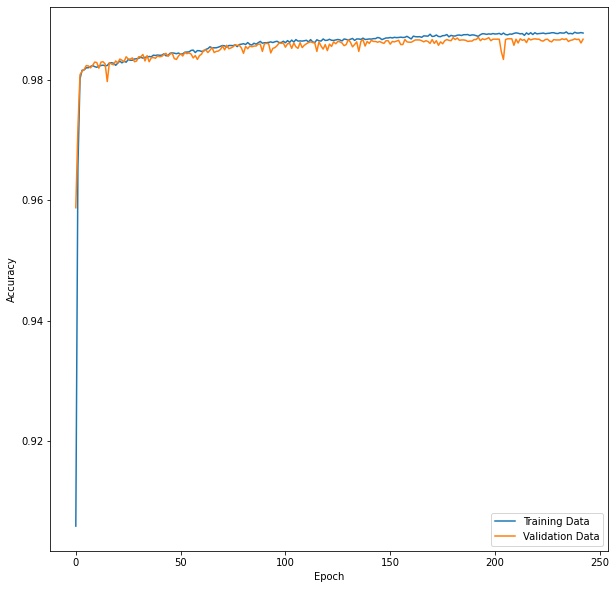

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  512

Predictions:
  Accuracy: 98.82%
  Precision: 98.88%
  Recall: 91.30%
  F1-score: 0.95
  Validation Accuracy: 98.67%



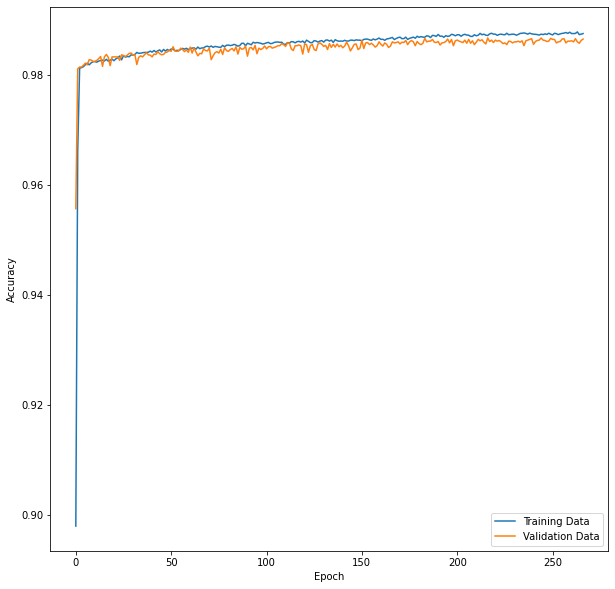

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 99.13%
  Precision: 98.94%
  Recall: 93.83%
  F1-score: 0.96
  Validation Accuracy: 98.84%



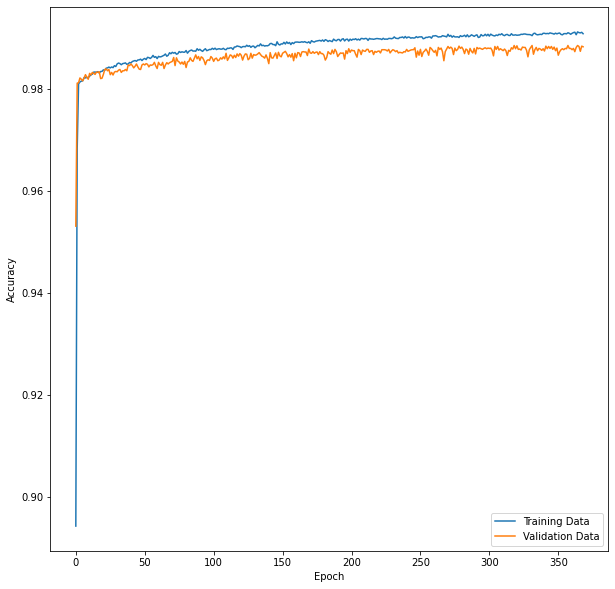

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  256

Predictions:
  Accuracy: 98.79%
  Precision: 99.02%
  Recall: 90.89%
  F1-score: 0.95
  Validation Accuracy: 98.65%



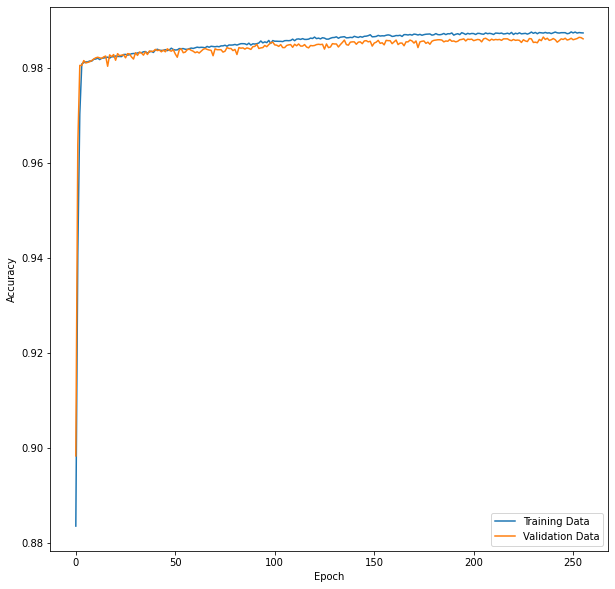

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  512

Predictions:
  Accuracy: 98.72%
  Precision: 98.47%
  Recall: 90.87%
  F1-score: 0.95
  Validation Accuracy: 98.57%



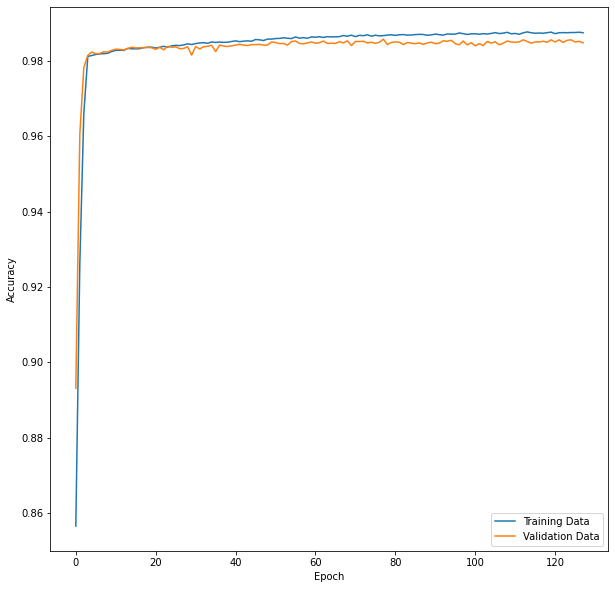

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  16
Epochs:  1024

Predictions:
  Accuracy: 98.74%
  Precision: 98.73%
  Recall: 90.76%
  F1-score: 0.95
  Validation Accuracy: 98.72%



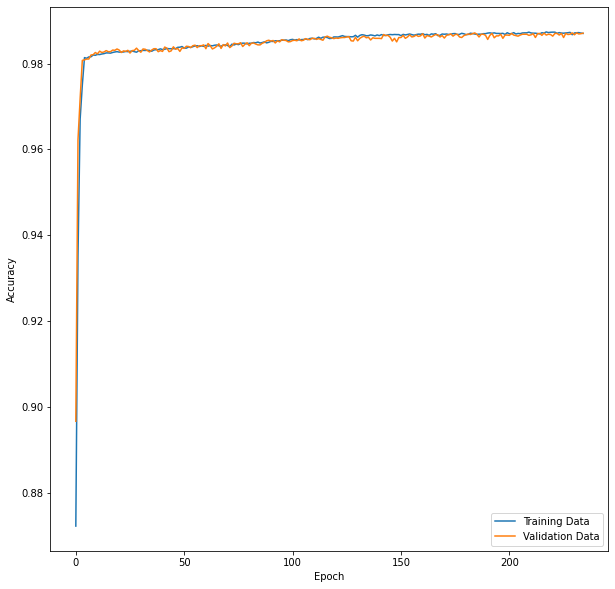

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  256

Predictions:
  Accuracy: 98.74%
  Precision: 98.80%
  Recall: 90.69%
  F1-score: 0.95
  Validation Accuracy: 98.67%



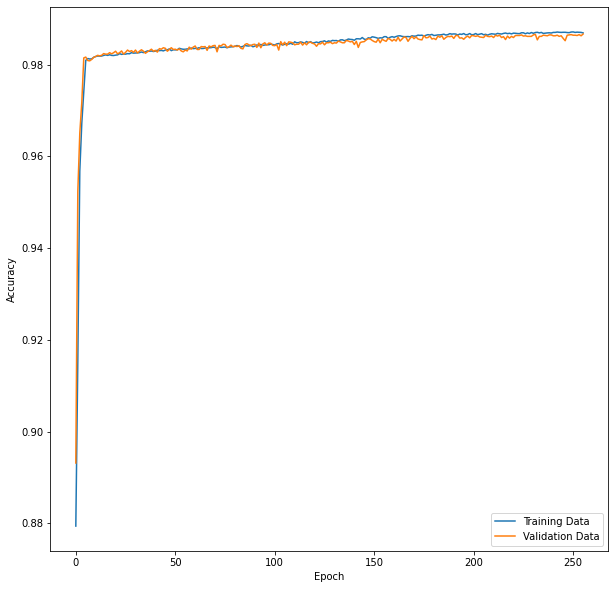

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  512

Predictions:
  Accuracy: 98.80%
  Precision: 98.81%
  Recall: 91.23%
  F1-score: 0.95
  Validation Accuracy: 98.63%



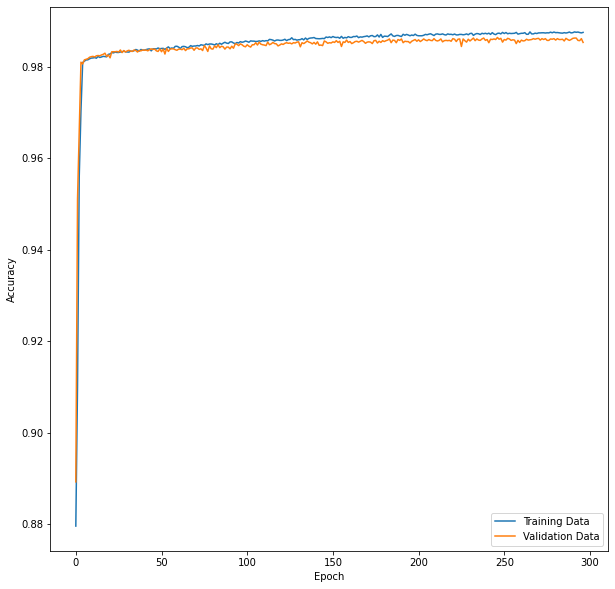

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  32
Epochs:  1024

Predictions:
  Accuracy: 98.84%
  Precision: 98.44%
  Recall: 91.90%
  F1-score: 0.95
  Validation Accuracy: 98.62%



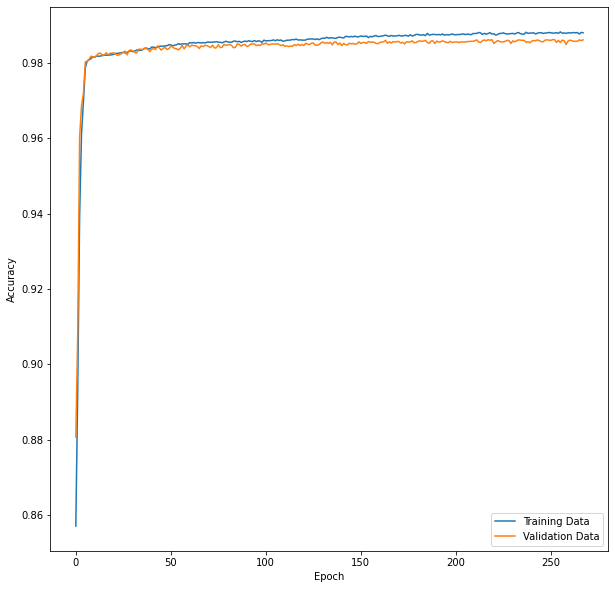

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  256

Predictions:
  Accuracy: 98.75%
  Precision: 98.31%
  Recall: 91.23%
  F1-score: 0.95
  Validation Accuracy: 98.62%



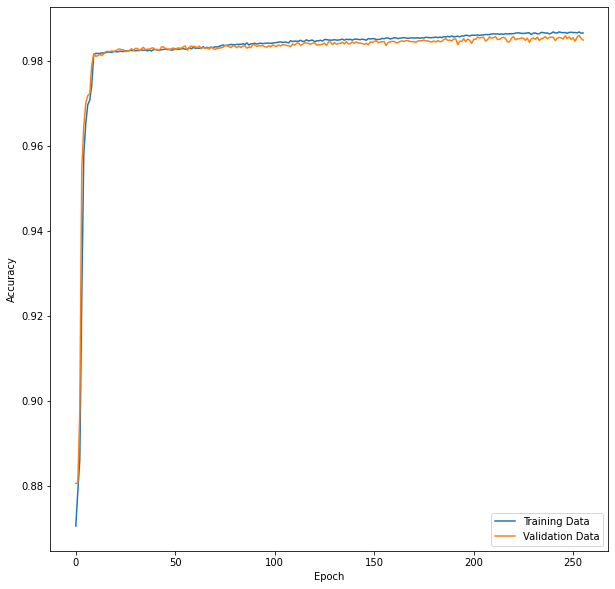

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  512

Predictions:
  Accuracy: 98.67%
  Precision: 98.60%
  Recall: 90.33%
  F1-score: 0.94
  Validation Accuracy: 98.67%



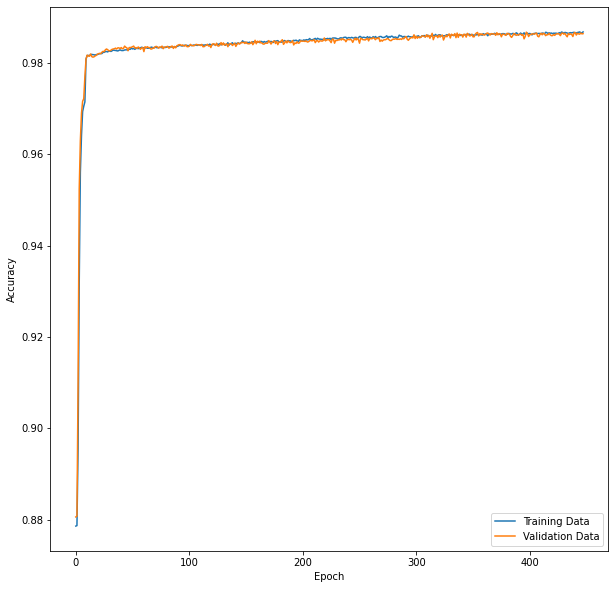

------------------------------------


------------------------------------
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  64
Epochs:  1024

Predictions:
  Accuracy: 98.57%
  Precision: 98.05%
  Recall: 90.02%
  F1-score: 0.94
  Validation Accuracy: 98.54%



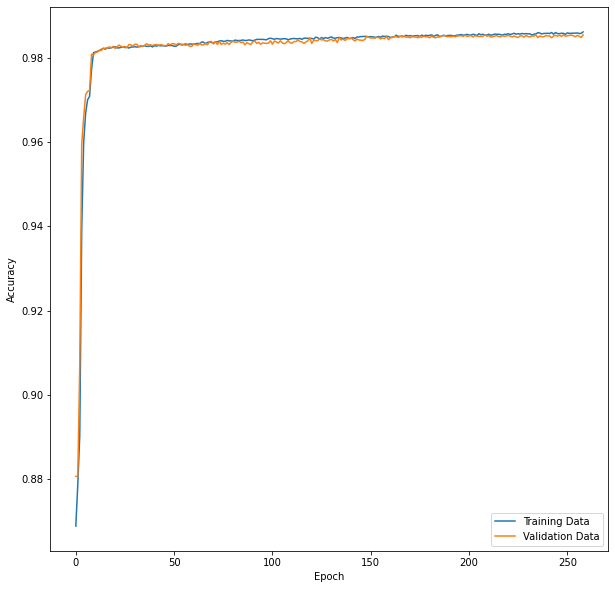

------------------------------------


----- 'Best' Hyperparamaters -----
Layers:  3
Neurons:  16
Activation:  sigmoid
Optimization:  nadam
Batch Size:  8
Epochs:  1024

Predictions:
  Accuracy: 99.13%
  Precision: 98.94%
  Recall: 93.83%
  F1-score: 0.96
  Validation Accuracy: 98.84%



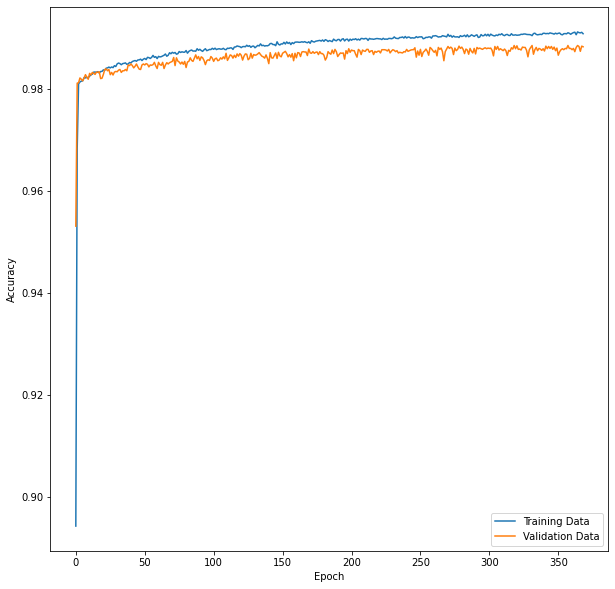

In [27]:
# 3-layered / sigmoid / nadam
training = (XTRAIN, YTRAIN)
validation = (XVALID, YVALID)
layersArr = [3]
neuronsArr = [2, 4, 8, 16]
activationsArr = ['sigmoid']
optimizationsArr = ['nadam']
batchSizesArr = [8, 16, 32, 64]
epochsArr = [256, 512, 1024]

bestHyperparameters = optimize_hyperparameters_acc(training, validation, layersArr, neuronsArr, activationsArr, optimizationsArr, batchSizesArr, epochsArr)

### Feature Importance and Reduction

#### Model

In [32]:
# Hyper-Parameters
headers = list(data.columns)
training = (XTRAIN, YTRAIN)
validation = (XVALID, YVALID)
architecture = [[1, 'sigmoid'],
                [16, 'sigmoid'],
                [16, 'sigmoid']]
compilation = ['mse', 'nadam', ['mse', 'acc']]
fit = [8, 1024]

#### Feature Isolation

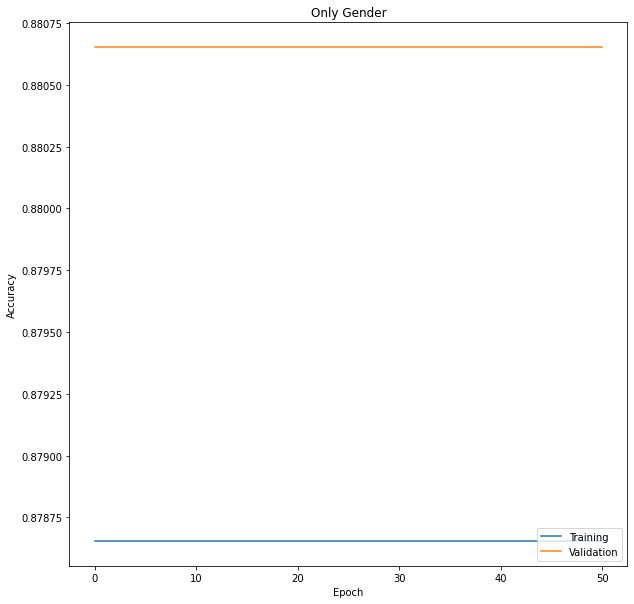

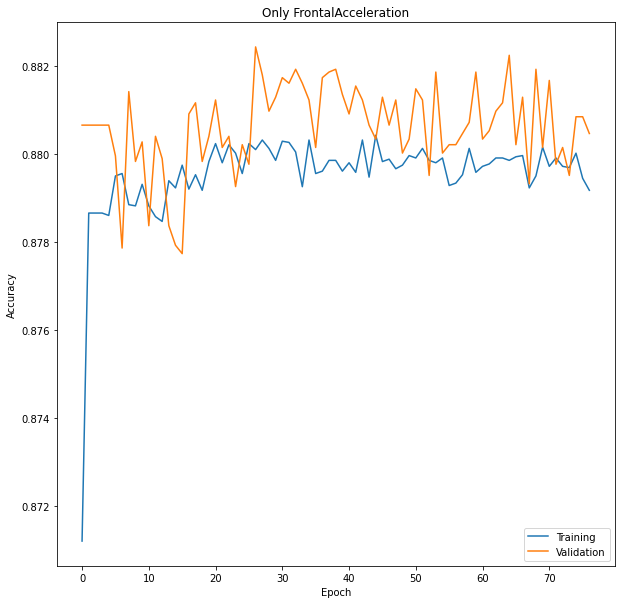

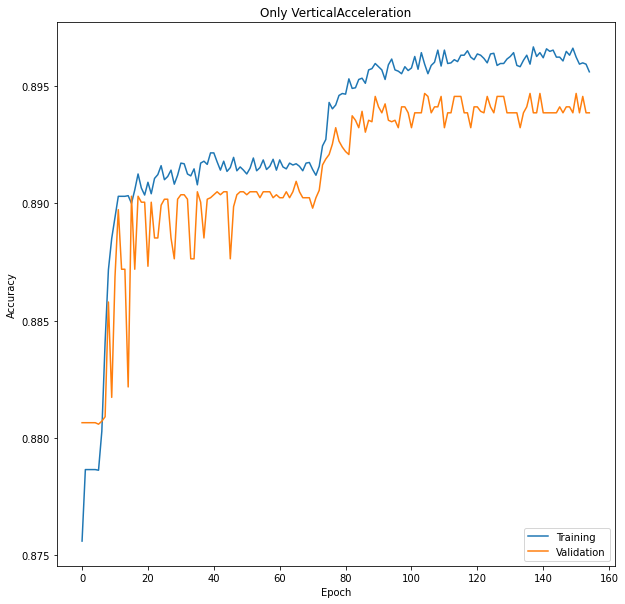

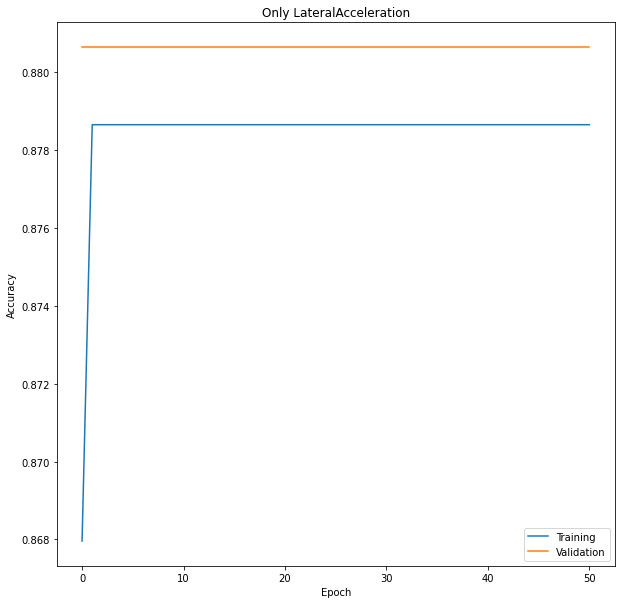

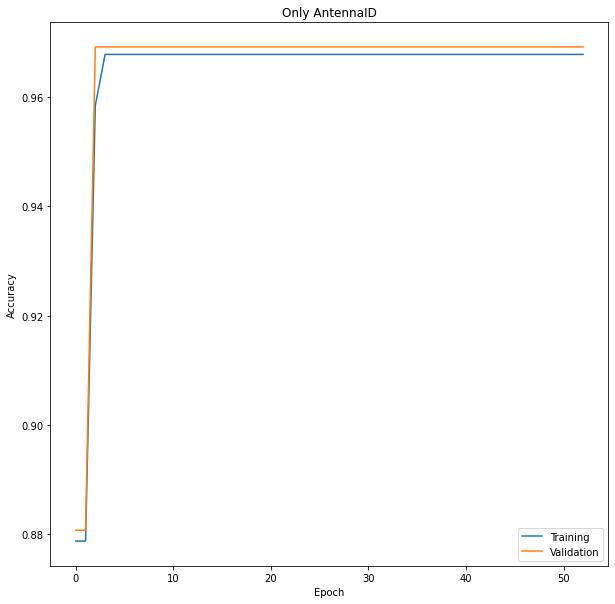

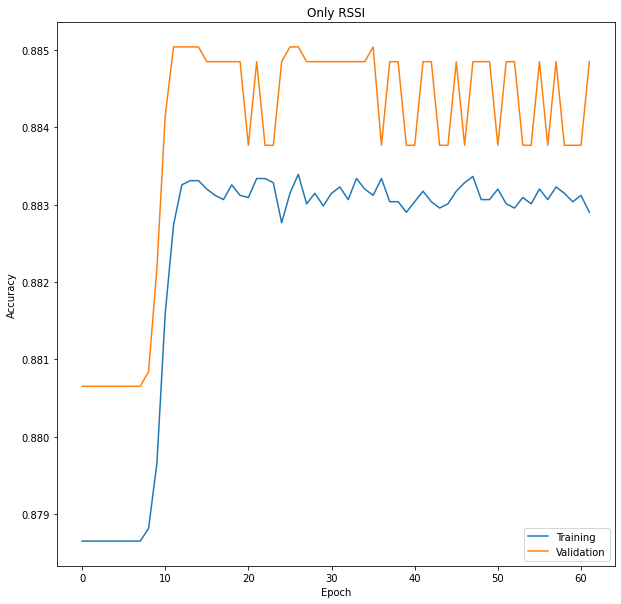

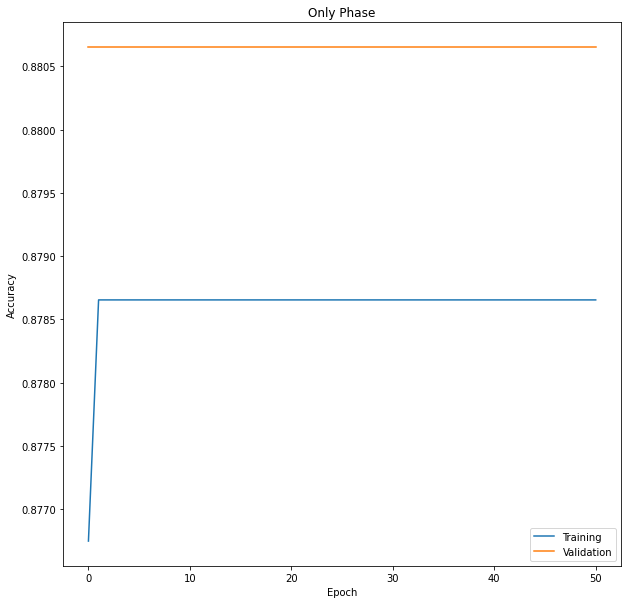

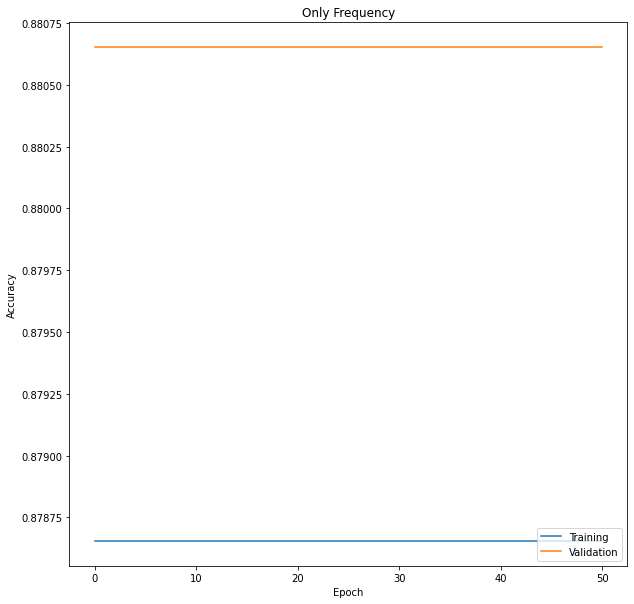

In [33]:
isolationValues = rfe_individual_acc(headers, training, validation, architecture, compilation, fit)

In [35]:
featureIsolation = pd.DataFrame({'Feature': isolationValues.keys(), 'Accuracy': isolationValues.values()}, columns=['Feature', 'Accuracy'])
featureIsolation.style

,Feature,Accuracy
0,Gender,0.880653
1,FrontalAcceleration,0.882431
2,VerticalAcceleration,0.894690
3,LateralAcceleration,0.880653
4,AntennaID,0.969258
5,RSSI,0.885036
6,Phase,0.880653
7,Frequency,0.880653


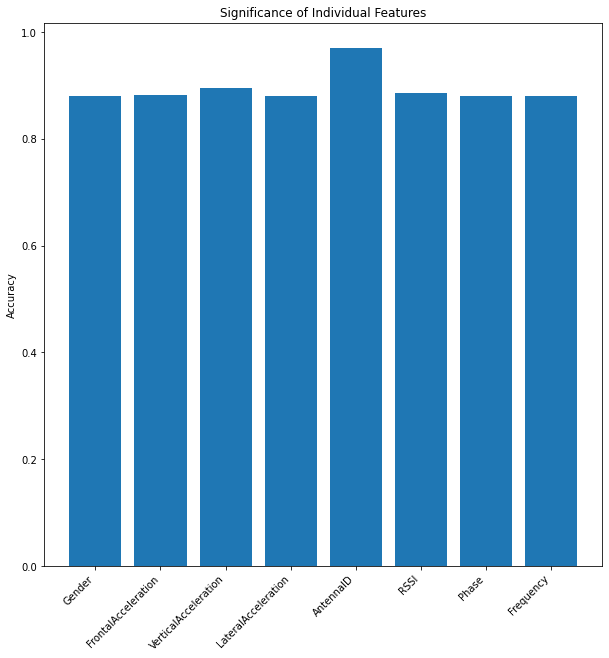

In [36]:
fig, ax = plt.subplots()
ax.bar(featureIsolation['Feature'], featureIsolation['Accuracy'])
ax.set_ylabel('Accuracy')
ax.set_title('Significance of Individual Features')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

#### Feature Exclusion

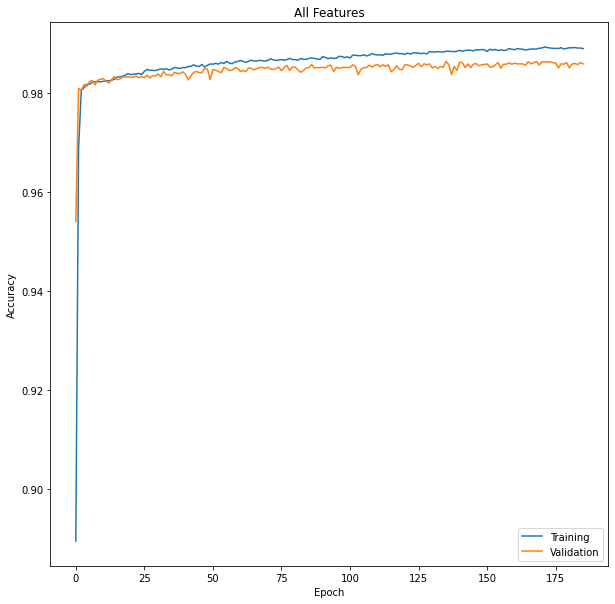

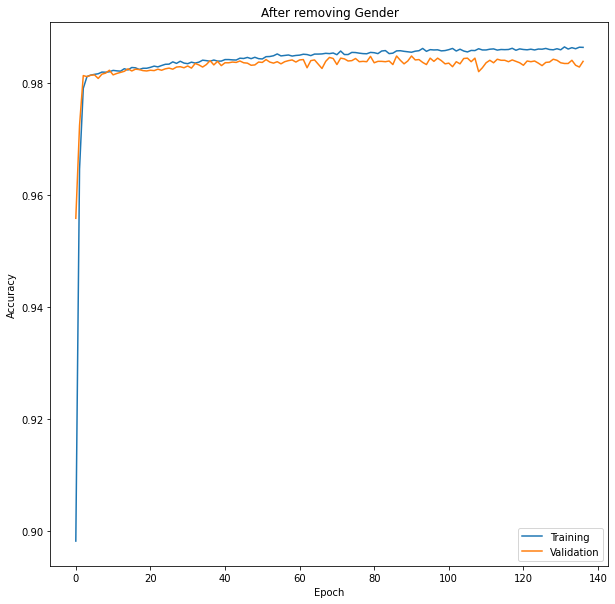

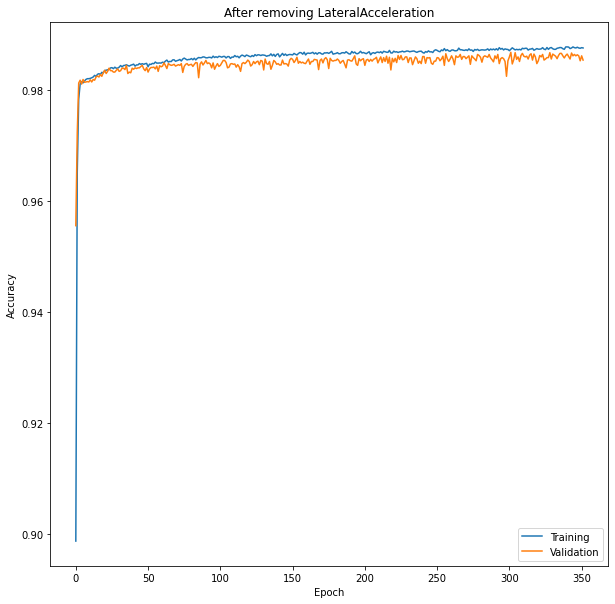

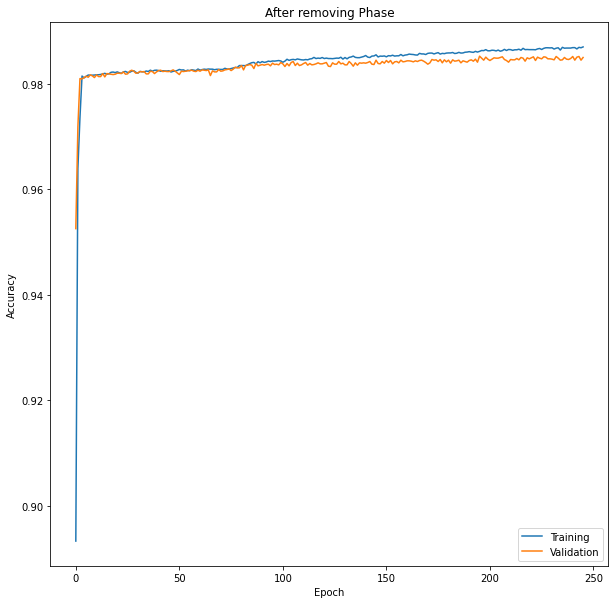

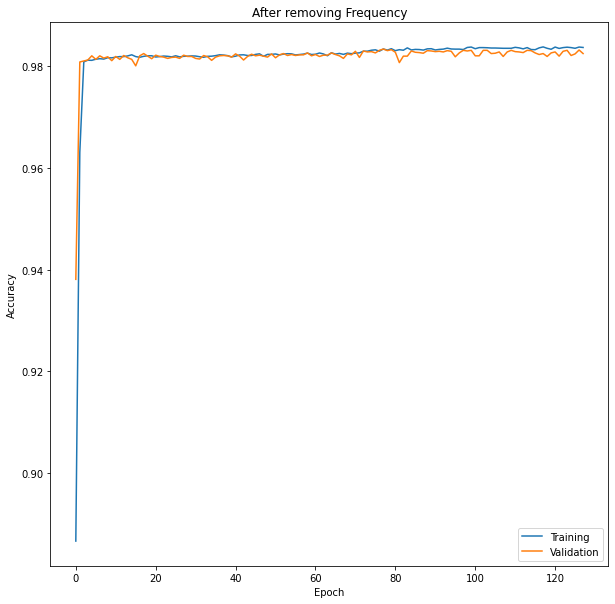

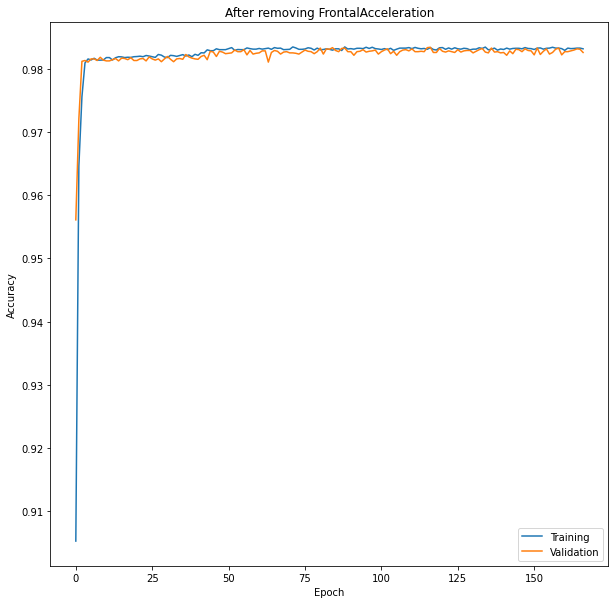

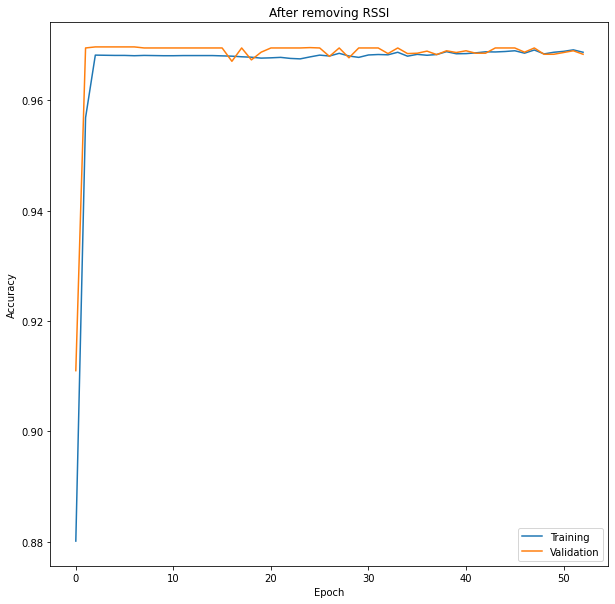

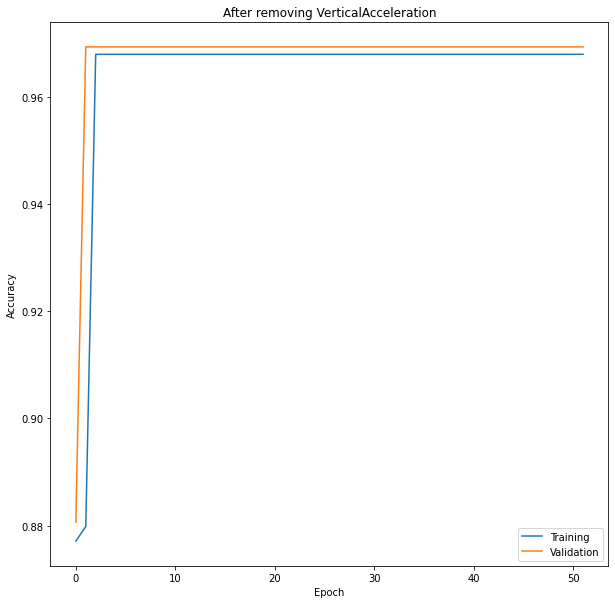

In [37]:
# Sort features by importance
featureIsolation = featureIsolation.sort_values(by=['Accuracy'], ascending=True)
columnRanks = list(featureIsolation.index.values)

exclusionValues = rfe_exclusion_acc(columnRanks, headers.copy(), training, validation, architecture, compilation, fit)

In [38]:
featureExclusion = pd.DataFrame({'Excluded Feature': exclusionValues.keys(), 'Accuracy': exclusionValues.values()}, columns=['Excluded Feature', 'Accuracy'])
featureExclusion.style

,Excluded Feature,Accuracy
0,All Features,0.986408
1,After removing Gender,0.984820
2,After removing LateralAcceleration,0.986725
3,After removing Phase,0.985264
4,After removing Frequency,0.983359
5,After removing FrontalAcceleration,0.983422
6,After removing RSSI,0.969639
7,After removing VerticalAcceleration,0.969258


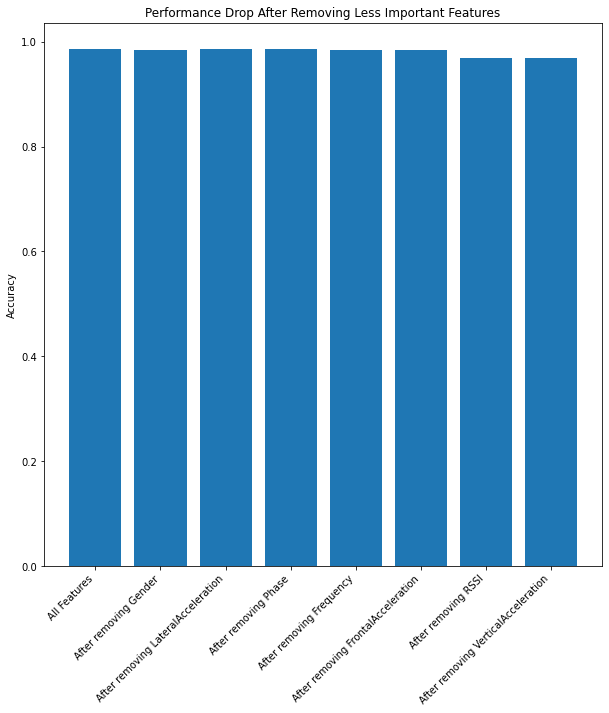

In [39]:
fig, ax = plt.subplots()
ax.bar(featureExclusion['Excluded Feature'], featureExclusion['Accuracy'])
ax.set_ylabel('Accuracy')
ax.set_title('Performance Drop After Removing Less Important Features')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

#### Evaluation

In [43]:
# Remove columns from dataset
removedFeatures = [0, 1, 3, 6, 7]

optXTRAIN = np.delete(XTRAIN, removedFeatures, axis=1)
optXVALID = np.delete(XVALID, removedFeatures, axis=1)

optTraining = (optXTRAIN, YTRAIN)
optValidation = (optXVALID, YVALID)

In [45]:
# Build, train, and evaluate model
model = build_model(architecture, len(optTraining[0][0,:]))
history = train_model_acc(model, optTraining, optValidation, compilation, fit)
acc = evaluate_model_acc(model, history, optTraining, optValidation)


Predictions:
  Accuracy: 98.26%
  Precision: 97.99%
  Recall: 87.46%
  F1-score: 0.92
  Validation Accuracy: 98.25%


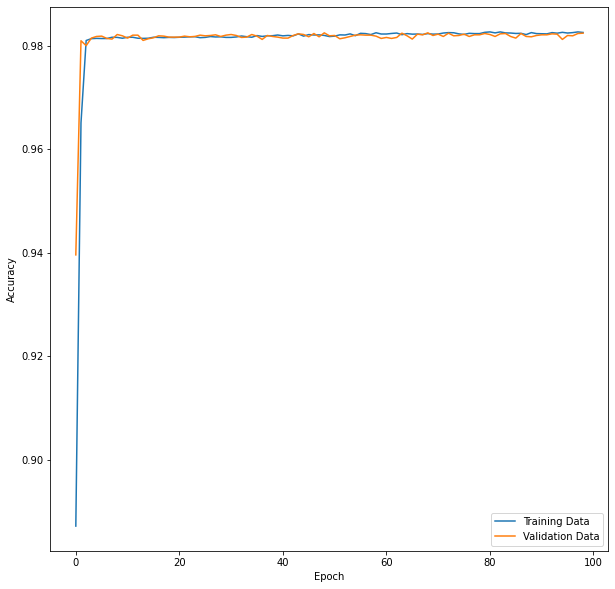

In [46]:
# Display results
model_statistics(model, optTraining, optValidation)
display_information_acc(model, history)